In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                        roc_curve, auc, roc_auc_score, log_loss)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from essentials import complete_preprocessing_pipeline
import copy
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from typing import Tuple, Dict
from essentials import normalization
from feature_sets_center_less import GenerateFeatures
from three_class_ncv_selectk_gn import ModifiedNestedCVOptimizer


/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../data/df_dict_imu.pkl', 'rb') as f:
    imu_dict = pickle.load(f)
with open('../data/df_dict_urineestimate_method1.pkl', 'rb') as f:
    urine_estimates_dict = pickle.load(f)
with open('../data/df_minze_dict.pkl', 'rb') as f:
    ground_truth_dict = pickle.load(f)

In [3]:
del imu_dict['subj_9_void4']
del imu_dict['subj_11_void2']

In [4]:
data_dict = copy.deepcopy(imu_dict)
labelled_imu_dict = complete_preprocessing_pipeline(data_dict, ground_truth_dict, 
                                target_fs=60,normalize_data=False, use_three_classes=True)

Step 1: Resampling data to 60 Hz...


Step 2: Processing each instance: 100%|██████████| 41/41 [00:00<00:00, 1343.91it/s]


In [5]:
# Add experiment_id to each dataframe and append to imu_dict
imu_list = []
for i, key in enumerate(labelled_imu_dict.keys()):
    df  = labelled_imu_dict[key]
    df['experiment_id'] = i + 1

    imu_list.append(df)

In [6]:
# Concatenate all the dataframes in imu_dict into a single dataframe
main_df = pd.concat(imu_list, ignore_index=True)

In [7]:
# Define window configurations (same as your pipeline)
window_configs = [
    (1, 0.0), (1, 0.5), (1, 0.8),
    (2, 0.0), (2, 0.5), (2, 0.8),
    (3, 0.0), (3, 0.5), (3, 0.8),
    (4, 0.0), (4, 0.5), (4, 0.8),
    (5, 0.0), (5, 0.5), (5, 0.8)
]

def dataframe_to_dict_by_experiment(df: pd.DataFrame) -> dict:
    """Convert DataFrame to dictionary with experiment_id as key"""
    experiment_dict = {}
    for exp_id in df['experiment_id'].unique():
        exp_data = df[df['experiment_id'] == exp_id].copy()
        exp_data = exp_data.drop(columns=['experiment_id'])
        # IMPORTANT: Reset index to avoid KeyError in feature extraction
        exp_data = exp_data.reset_index(drop=True)
        experiment_dict[f'exp_{exp_id}'] = exp_data
    return experiment_dict

def extract_features_from_dict(data_dict: dict, window_size: float, overlap: float) -> pd.DataFrame:
    """Extract features from dictionary of DataFrames"""
    all_features = []
    
    for exp_key, df in data_dict.items():
        actual_exp_id = int(exp_key.split('_')[1])
        
        analyzer = GenerateFeatures(fs=60, window_duration=window_size, overlap=overlap)
        features, _ = analyzer.analyze_multi_axis_imu(df)
        
        table = analyzer.create_summary_table()
        table['experiment_id'] = actual_exp_id
        all_features.append(table)
    
    return pd.concat(all_features, ignore_index=True)


In [8]:
# Store results for all window configurations
all_global_norm_results = {}

In [9]:
n_outer_splits = 5
n_inner_splits = 3

outer_cv = StratifiedGroupKFold(n_splits=n_outer_splits, shuffle=True, random_state=42)
inner_cv = StratifiedGroupKFold(n_splits=n_inner_splits, shuffle=True, random_state=42)

# Loop through each window configuration
for window_size, overlap in window_configs:
    print(f"\n{'='*80}")
    print(f"PROCESSING: {window_size}s window, {overlap} overlap")
    print(f"{'='*80}")
    
    config_fold_results = []

    # Split dictionary into training and testing sets based on void instances
    for fold_id, (train_id, test_id) in enumerate(outer_cv.split(main_df, y=main_df['label'], groups=main_df['experiment_id'])):
        print(f"Fold {fold_id + 1}")
        data_train, data_test = main_df.iloc[train_id], main_df.iloc[test_id]
        _, _ = main_df['label'].iloc[train_id], main_df['label'].iloc[test_id]
        groups_train, groups_test = main_df['experiment_id'].iloc[train_id], main_df['experiment_id'].iloc[test_id]

        
        # Apply global normalization
        data_train_norm, data_test_norm = normalization(data_train, data_test)

        print(f"✓ Applied global normalization")
        print(f"Train experiments: {sorted(groups_train.unique())}")
        print(f"Test experiments: {sorted(groups_test.unique())}")
    
        # Convert normalized DataFrames to dictionaries for feature extraction
        train_dict = dataframe_to_dict_by_experiment(data_train_norm)
        test_dict = dataframe_to_dict_by_experiment(data_test_norm)
        
        # Extract features
        print(f"Extracting features...")
        train_features = extract_features_from_dict(train_dict, window_size, overlap)
        test_features = extract_features_from_dict(test_dict, window_size, overlap)
        
        print(f"Train features shape: {train_features.shape}")
        print(f"Test features shape: {test_features.shape}")
        
        # Store this fold's results
        fold_result = {
            'fold': fold_id + 1,
            'window_size': window_size,
            'overlap': overlap,
            'train_features': train_features,
            'test_features': test_features,
            'original_train_groups': groups_train,
            'original_test_groups': groups_test
        }
        config_fold_results.append(fold_result)
        
    # Store results for this configuration - for each window size and overlap, we get 5 fold results
    overlap_str = 'no' if overlap == 0.0 else str(overlap)
    config_key = f"{window_size}s_{overlap_str}"
    all_global_norm_results[config_key] = config_fold_results
    
    print(f"\n✓ Completed {config_key}: {len(config_fold_results)} folds")
    
print(f"\n{'='*80}")
print("FEATURE EXTRACTION COMPLETED FOR ALL CONFIGURATIONS")
print(f"{'='*80}")

# # Show summary
# for config_key, fold_results in all_global_norm_results.items():
#     print(f"\n{config_key}:")
#     for fold_result in fold_results:
#         fold_id = fold_result['fold']
#         train_shape = fold_result['train_features'].shape
#         test_shape = fold_result['test_features'].shape
#         print(f"  Fold {fold_result['fold']}: Train{train_shape}, Test{test_shape}")
        
#         # Save train and test features to CSV for inspection
#         fold_result['train_features'].to_csv(
#             f'/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/extracted_features/three_class/train_{config_key}_fold{fold_id}.csv', 
#             index=False
#         )
#         fold_result['test_features'].to_csv(
#             f'/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/extracted_features/three_class/test_{config_key}_fold{fold_id}.csv', 
#             index=False
#         )
        



PROCESSING: 1s window, 0.0 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 16.34it/s]


Train features shape: (2020, 107)
Test features shape: (378, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Train features shape: (1883, 107)
Test features shape: (515, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Train features shape: (1757, 107)
Test features shape: (641, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 15.51it/s]


Train features shape: (1896, 107)
Test features shape: (502, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 15.07it/s]


Train features shape: (2036, 107)
Test features shape: (362, 107)

✓ Completed 1s_no: 5 folds

PROCESSING: 1s window, 0.5 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  8.21it/s]


Train features shape: (4026, 107)
Test features shape: (756, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


Train features shape: (3755, 107)
Test features shape: (1027, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]


Train features shape: (3504, 107)
Test features shape: (1278, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  7.98it/s]


Train features shape: (3783, 107)
Test features shape: (999, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  6.61it/s]


Train features shape: (4060, 107)
Test features shape: (722, 107)

✓ Completed 1s_0.5: 5 folds

PROCESSING: 1s window, 0.8 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]


Train features shape: (10034, 107)
Test features shape: (1882, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Train features shape: (9356, 107)
Test features shape: (2560, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Train features shape: (8731, 107)
Test features shape: (3185, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


Train features shape: (9427, 107)
Test features shape: (2489, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Train features shape: (10116, 107)
Test features shape: (1800, 107)

✓ Completed 1s_0.8: 5 folds

PROCESSING: 2s window, 0.0 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 32.40it/s]


Train features shape: (1002, 107)
Test features shape: (186, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  9.28it/s]


Train features shape: (932, 107)
Test features shape: (256, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]


Train features shape: (870, 107)
Test features shape: (318, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 30.59it/s]


Train features shape: (939, 107)
Test features shape: (249, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 27.12it/s]


Train features shape: (1009, 107)
Test features shape: (179, 107)

✓ Completed 2s_no: 5 folds

PROCESSING: 2s window, 0.5 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 16.71it/s]


Train features shape: (1987, 107)
Test features shape: (370, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


Train features shape: (1850, 107)
Test features shape: (507, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


Train features shape: (1724, 107)
Test features shape: (633, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 15.38it/s]


Train features shape: (1864, 107)
Test features shape: (493, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 15.18it/s]


Train features shape: (2003, 107)
Test features shape: (354, 107)

✓ Completed 2s_0.5: 5 folds

PROCESSING: 2s window, 0.8 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]


Train features shape: (4944, 107)
Test features shape: (922, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


Train features shape: (4604, 107)
Test features shape: (1262, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Train features shape: (4292, 107)
Test features shape: (1574, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


Train features shape: (4641, 107)
Test features shape: (1225, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


Train features shape: (4983, 107)
Test features shape: (883, 107)

✓ Completed 2s_0.8: 5 folds

PROCESSING: 3s window, 0.0 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 48.36it/s]


Train features shape: (663, 107)
Test features shape: (123, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 13.79it/s]


Train features shape: (618, 107)
Test features shape: (168, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  9.28it/s]


Train features shape: (574, 107)
Test features shape: (212, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 45.20it/s]


Train features shape: (622, 107)
Test features shape: (164, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 41.32it/s]


Train features shape: (667, 107)
Test features shape: (119, 107)

✓ Completed 3s_no: 5 folds

PROCESSING: 3s window, 0.5 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 25.25it/s]


Train features shape: (1309, 107)
Test features shape: (244, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  6.95it/s]


Train features shape: (1219, 107)
Test features shape: (334, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [2:40:17<00:00, 1602.98s/it]  


Train features shape: (1135, 107)
Test features shape: (418, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 15.80it/s]


Train features shape: (1229, 107)
Test features shape: (324, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 21.73it/s]


Train features shape: (1320, 107)
Test features shape: (233, 107)

✓ Completed 3s_0.5: 5 folds

PROCESSING: 3s window, 0.8 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  9.02it/s]


Train features shape: (3245, 107)
Test features shape: (604, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


Train features shape: (3020, 107)
Test features shape: (829, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


Train features shape: (2810, 107)
Test features shape: (1039, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  9.19it/s]


Train features shape: (3047, 107)
Test features shape: (802, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  8.88it/s]


Train features shape: (3274, 107)
Test features shape: (575, 107)

✓ Completed 3s_0.8: 5 folds

PROCESSING: 4s window, 0.0 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 61.47it/s]


Train features shape: (493, 107)
Test features shape: (90, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 17.35it/s]


Train features shape: (457, 107)
Test features shape: (126, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 12.02it/s]


Train features shape: (425, 107)
Test features shape: (158, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 55.92it/s]


Train features shape: (461, 107)
Test features shape: (122, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 56.27it/s]


Train features shape: (496, 107)
Test features shape: (87, 107)

✓ Completed 4s_no: 5 folds

PROCESSING: 4s window, 0.5 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 30.30it/s]


Train features shape: (969, 107)
Test features shape: (178, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  8.80it/s]


Train features shape: (899, 107)
Test features shape: (248, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


Train features shape: (837, 107)
Test features shape: (310, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 29.72it/s]


Train features shape: (907, 107)
Test features shape: (240, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 27.97it/s]


Train features shape: (976, 107)
Test features shape: (171, 107)

✓ Completed 4s_0.5: 5 folds

PROCESSING: 4s window, 0.8 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 12.99it/s]


Train features shape: (2397, 107)
Test features shape: (443, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Train features shape: (2227, 107)
Test features shape: (613, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]


Train features shape: (2071, 107)
Test features shape: (769, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 11.76it/s]


Train features shape: (2247, 107)
Test features shape: (593, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 11.96it/s]


Train features shape: (2418, 107)
Test features shape: (422, 107)

✓ Completed 4s_0.8: 5 folds

PROCESSING: 5s window, 0.0 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 74.37it/s]


Train features shape: (391, 107)
Test features shape: (72, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 21.05it/s]


Train features shape: (363, 107)
Test features shape: (100, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 14.35it/s]


Train features shape: (338, 107)
Test features shape: (125, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 67.09it/s]


Train features shape: (366, 107)
Test features shape: (97, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 67.30it/s]


Train features shape: (394, 107)
Test features shape: (69, 107)

✓ Completed 5s_no: 5 folds

PROCESSING: 5s window, 0.5 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 37.78it/s]


Train features shape: (764, 107)
Test features shape: (141, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 10.21it/s]


Train features shape: (709, 107)
Test features shape: (196, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00,  7.36it/s]


Train features shape: (659, 107)
Test features shape: (246, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 36.76it/s]


Train features shape: (717, 107)
Test features shape: (188, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 27.48it/s]


Train features shape: (771, 107)
Test features shape: (134, 107)

✓ Completed 5s_0.5: 5 folds

PROCESSING: 5s window, 0.8 overlap
Fold 1
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(5), np.int64(12), np.int64(13), np.int64(16), np.int64(21), np.int64(30), np.int64(31), np.int64(34)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 15.78it/s]


Train features shape: (1888, 107)
Test features shape: (346, 107)
Fold 2
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(2), np.int64(4), np.int64(7), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(27)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]


Train features shape: (1751, 107)
Test features shape: (483, 107)
Fold 3
✓ Applied global normalization
Train experiments: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(41)]
Test experiments: [np.int64(1), np.int64(10), np.int64(11), np.int64(14), np.int64(25), np.int64(35), np.int64(39), np.int64(40)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


Train features shape: (1625, 107)
Test features shape: (609, 107)
Fold 4
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(38), np.int64(39), np.int64(40)]
Test experiments: [np.int64(3), np.int64(6), np.int64(17), np.int64(23), np.int64(26), np.int64(33), np.int64(36), np.int64(37), np.int64(41)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 13.71it/s]


Train features shape: (1768, 107)
Test features shape: (466, 107)
Fold 5
✓ Applied global normalization
Train experiments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39), np.int64(40), np.int64(41)]
Test experiments: [np.int64(8), np.int64(9), np.int64(15), np.int64(24), np.int64(28), np.int64(29), np.int64(32), np.int64(38)]
Extracting features...


Analyzing: 100%|██████████| 6/6 [00:00<00:00, 13.01it/s]


Train features shape: (1904, 107)
Test features shape: (330, 107)

✓ Completed 5s_0.8: 5 folds

FEATURE EXTRACTION COMPLETED FOR ALL CONFIGURATIONS


In [ ]:
# # pickle all_global_norm_results
# with open('/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/three_class_global_norm_extracted_features.pkl', 'wb') as f:
#     pickle.dump(all_global_norm_results,f)

# Nested CV with pre-split data - save each dataset separately

In [11]:
# open pickled results
with open('/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/three_class_global_norm_extracted_features.pkl', 'rb') as f:
    all_global_norm_results = pickle.load(f)

In [12]:
def run_global_norm_nested_cv_with_class(all_global_norm_results: Dict, base_save_path: str, 
                                        n_inner_folds: int = 3, 
                                        n_trials: int = 50) -> ModifiedNestedCVOptimizer:
    """
    Convenience function to run global normalization nested CV using the class-based approach.
    
    Parameters:
    -----------
    all_global_norm_results : Dict
        Results from your global normalization pipeline
    base_save_path : str
        Directory to save results
    positive_class : str
        Positive class label
    n_inner_folds : int
        Number of inner CV folds for hyperparameter optimization
    n_trials : int
        Number of optimization trials per model
        
    Returns:
    --------
    ModifiedNestedCVOptimizer instance with all results
    """
    
    # Initialize the optimizer
    optimizer = ModifiedNestedCVOptimizer(
        n_inner_folds=n_inner_folds,
        n_trials=n_trials,
        random_state=42
    )
    
    # Run all configurations
    all_results = optimizer.run_all_configurations(all_global_norm_results, base_save_path)
    
    # Print summary
    best_config, best_model, best_f1 = optimizer.get_best_configuration()
    print(f"\nBEST OVERALL RESULT:")
    print(f"Configuration: {best_config}")
    print(f"Model: {best_model}")
    print(f"F1 Score (positive class): {best_f1:.4f}")
    
    return optimizer


[I 2025-09-20 22:55:19,498] A new study created in memory with name: no-name-98fda738-61b3-43f6-9358-bd4775a360fc



GLOBAL NORMALIZATION NESTED CV - CLASS-BASED APPROACH
Base save path: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class
Configurations to process: 15

PROCESSING CONFIGURATION: 1s_no

  OUTER FOLD 1
  Train: (2020, 107), Test: (378, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-20 22:55:20,921] Trial 0 finished with value: -0.6633519959316031 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6633519959316031.
[I 2025-09-20 22:55:21,372] Trial 1 finished with value: -0.6547456198398659 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.6547456198398659.
[I 2025-09-20 22:55:28,373] Trial 2 finished with value: -4.734611287458243 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105


[I 2025-09-20 22:58:07,203] A new study created in memory with name: no-name-2e6e3295-1be6-4078-80fb-72f96aef7182


      Acc: 0.7989, F1(+): 0.8006
    Optimizing XGB...


[I 2025-09-20 22:58:07,786] Trial 0 finished with value: -0.6661205344665002 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6661205344665002.
[I 2025-09-20 22:58:11,180] Trial 1 finished with value: -0.630310129851254 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with value

      Features selected: 31/105
      Acc: 0.7593, F1(+): 0.7596
    Optimizing DT...


[I 2025-09-20 22:59:56,712] Trial 3 finished with value: -5.948386832826383 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -0.9714767915696817.
[I 2025-09-20 22:59:56,763] Trial 4 finished with value: -6.832035657654565 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9714767915696817.
[I 2025-09-20 22:59:57,096] Trial 5 finished with value: -8.252543721209495 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_sample

      Features selected: 42/105
      Acc: 0.7275, F1(+): 0.7281

  OUTER FOLD 2
  Train: (1883, 107), Test: (515, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-20 23:00:00,886] Trial 0 finished with value: -0.5911495359590258 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.5911495359590258.
[I 2025-09-20 23:00:01,351] Trial 1 finished with value: -0.5502404096453212 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.5502404096453212.
[I 2025-09-20 23:00:07,610] Trial 2 finished with value: -3.9379644507245133 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'c

      Features selected: 31/105


[I 2025-09-20 23:02:08,429] A new study created in memory with name: no-name-7113b11b-6ab1-49a5-b2ef-1edca97b923d


      Acc: 0.6505, F1(+): 0.6365
    Optimizing XGB...


[I 2025-09-20 23:02:08,941] Trial 0 finished with value: -0.5007895120284048 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5007895120284048.
[I 2025-09-20 23:02:11,840] Trial 1 finished with value: -0.5350561721280368 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 73/105
      Acc: 0.6330, F1(+): 0.6114
    Optimizing DT...


[I 2025-09-20 23:03:37,940] Trial 4 finished with value: -5.740240732603236 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0172776011806437.
[I 2025-09-20 23:03:38,222] Trial 5 finished with value: -5.428484115422248 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0172776011806437.
[I 2025-09-20 23:03:38,282] Trial 6 finished with value: -5.338174059125873 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_

      Features selected: 52/105
      Acc: 0.6388, F1(+): 0.6354

  OUTER FOLD 3
  Train: (1757, 107), Test: (641, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-20 23:03:43,622] Trial 0 finished with value: -0.6689016338206096 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6689016338206096.
[I 2025-09-20 23:03:44,080] Trial 1 finished with value: -0.7162656699829896 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6689016338206096.
[I 2025-09-20 23:03:50,113] Trial 2 finished with value: -5.379988333669167 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.7520, F1(+): 0.7307
    Optimizing XGB...


[I 2025-09-20 23:05:51,185] Trial 0 finished with value: -0.6919477966777352 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6919477966777352.
[I 2025-09-20 23:05:54,157] Trial 1 finished with value: -0.6333290909086742 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 73/105
      Acc: 0.7426, F1(+): 0.7233
    Optimizing DT...


[I 2025-09-20 23:07:45,873] Trial 4 finished with value: -7.4328110812806685 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9267609522807828.
[I 2025-09-20 23:07:46,164] Trial 5 finished with value: -7.816678346839244 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9267609522807828.
[I 2025-09-20 23:07:46,225] Trial 6 finished with value: -6.462198612744949 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min

      Features selected: 73/105
      Acc: 0.3370, F1(+): 0.3233

  OUTER FOLD 4
  Train: (1896, 107), Test: (502, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-20 23:07:50,013] Trial 0 finished with value: -0.6823939234796338 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6823939234796338.
[I 2025-09-20 23:07:50,452] Trial 1 finished with value: -0.7109339582413566 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6823939234796338.
[I 2025-09-20 23:07:58,793] Trial 2 finished with value: -5.832209254607424 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105
      Acc: 0.7928, F1(+): 0.7986
    Optimizing XGB...


[I 2025-09-20 23:11:06,577] Trial 0 finished with value: -0.7162251613597981 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7162251613597981.
[I 2025-09-20 23:11:10,095] Trial 1 finished with value: -0.6593758774683294 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 21/105
      Acc: 0.7948, F1(+): 0.8021
    Optimizing DT...


[I 2025-09-20 23:11:56,303] Trial 4 finished with value: -7.9822952466088894 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9991171292139187.
[I 2025-09-20 23:11:56,601] Trial 5 finished with value: -7.437598944603516 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9991171292139187.
[I 2025-09-20 23:11:56,664] Trial 6 finished with value: -6.33457179235262 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_

      Features selected: 84/105
      Acc: 0.6574, F1(+): 0.6470

  OUTER FOLD 5
  Train: (2036, 107), Test: (362, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-20 23:12:00,277] Trial 0 finished with value: -0.7051248308558066 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7051248308558066.
[I 2025-09-20 23:12:00,740] Trial 1 finished with value: -0.6879419865798698 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.6879419865798698.
[I 2025-09-20 23:12:07,405] Trial 2 finished with value: -5.840109639644498 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 73/105
      Acc: 0.8260, F1(+): 0.8142
    Optimizing XGB...


[I 2025-09-20 23:14:25,519] Trial 0 finished with value: -0.7698740929967446 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7698740929967446.
[I 2025-09-20 23:14:29,354] Trial 1 finished with value: -0.6657126461533834 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 73/105
      Acc: 0.8039, F1(+): 0.7880
    Optimizing DT...


[I 2025-09-20 23:16:28,448] Trial 3 finished with value: -5.575339806295517 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -0.9644915529636685.
[I 2025-09-20 23:16:28,500] Trial 4 finished with value: -7.763471667993898 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9644915529636685.
[I 2025-09-20 23:16:28,822] Trial 5 finished with value: -8.185370030937811 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_sample

      Features selected: 52/105
      Acc: 0.6326, F1(+): 0.4354

✓ Configuration 1s_no completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/1s_no_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-20 23:16:33,184] A new study created in memory with name: no-name-f99ed471-240c-40fc-ae66-5782b6cc23a7


Confusion matrices saved to: plots_1s_no_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 1s_0.5

  OUTER FOLD 1
  Train: (4026, 107), Test: (756, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-20 23:16:34,981] Trial 0 finished with value: -0.6489411141624323 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6489411141624323.
[I 2025-09-20 23:16:36,013] Trial 1 finished with value: -0.6718181838765531 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6489411141624323.
[I 2025-09-20 23:16:51,312] Trial 2 finished with value: -5.731281569396228 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105
      Acc: 0.7712, F1(+): 0.7723
    Optimizing XGB...


[I 2025-09-20 23:27:48,899] Trial 0 finished with value: -0.7323937028501027 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7323937028501027.
[I 2025-09-20 23:27:55,937] Trial 1 finished with value: -0.646457561674952 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with value

      Features selected: 21/105
      Acc: 0.7831, F1(+): 0.7846
    Optimizing DT...


[I 2025-09-20 23:29:09,327] Trial 1 finished with value: -0.9496079219857668 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9496079219857668.
[I 2025-09-20 23:29:09,368] Trial 2 finished with value: -3.1365492271478765 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples_split': 13, 'clf__min_samples_leaf': 10, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9496079219857668.
[I 2025-09-20 23:29:09,447] Trial 3 finished with value: -7.135581873275037 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf_

      Features selected: 10/105
      Acc: 0.6415, F1(+): 0.6224

  OUTER FOLD 2
  Train: (3755, 107), Test: (1027, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-20 23:29:15,013] Trial 0 finished with value: -0.5839212184660291 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.5839212184660291.
[I 2025-09-20 23:29:16,232] Trial 1 finished with value: -0.5682830282732882 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.5682830282732882.
[I 2025-09-20 23:29:33,618] Trial 2 finished with value: -4.478372430850013 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 21/105
      Acc: 0.6524, F1(+): 0.6385
    Optimizing XGB...


[I 2025-09-20 23:33:14,849] Trial 0 finished with value: -0.5039403323584423 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5039403323584423.
[I 2025-09-20 23:33:20,621] Trial 1 finished with value: -0.5298478168190296 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 21/105
      Acc: 0.6534, F1(+): 0.6357
    Optimizing DT...


[I 2025-09-20 23:34:27,115] Trial 2 finished with value: -2.3426730064819283 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples_split': 13, 'clf__min_samples_leaf': 10, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0862762826868082.
[I 2025-09-20 23:34:27,187] Trial 3 finished with value: -6.080977324250743 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -1.0862762826868082.
[I 2025-09-20 23:34:27,257] Trial 4 finished with value: -5.238261955815429 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min

      Features selected: 52/105
      Acc: 0.5618, F1(+): 0.5496

  OUTER FOLD 3
  Train: (3504, 107), Test: (1278, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-20 23:34:32,200] Trial 0 finished with value: -0.6698567920199668 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6698567920199668.
[I 2025-09-20 23:34:33,341] Trial 1 finished with value: -0.7053738383880033 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6698567920199668.
[I 2025-09-20 23:34:51,571] Trial 2 finished with value: -6.359991074707257 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105
      Acc: 0.7418, F1(+): 0.7192
    Optimizing XGB...


[I 2025-09-20 23:37:01,126] Trial 0 finished with value: -0.7734941570629044 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7734941570629044.
[I 2025-09-20 23:37:04,743] Trial 1 finished with value: -0.6473374742811301 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 42/105
      Acc: 0.7543, F1(+): 0.7367
    Optimizing DT...


[I 2025-09-20 23:38:32,874] Trial 2 finished with value: -2.7887632638339617 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples_split': 13, 'clf__min_samples_leaf': 10, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0899895916811768.
[I 2025-09-20 23:38:32,937] Trial 3 finished with value: -7.53187430534091 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -1.0899895916811768.
[I 2025-09-20 23:38:33,001] Trial 4 finished with value: -6.299961181338806 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_

      Features selected: 105/105
      Acc: 0.5798, F1(+): 0.4991

  OUTER FOLD 4
  Train: (3783, 107), Test: (999, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-20 23:38:37,197] Trial 0 finished with value: -0.6990971858004725 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6990971858004725.
[I 2025-09-20 23:38:37,683] Trial 1 finished with value: -0.6963293054827883 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.6963293054827883.
[I 2025-09-20 23:38:41,955] Trial 2 finished with value: -6.290771589549227 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 52/105
      Acc: 0.7938, F1(+): 0.7963
    Optimizing XGB...


[I 2025-09-20 23:40:33,491] Trial 0 finished with value: -0.7572410132483439 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7572410132483439.
[I 2025-09-20 23:40:37,661] Trial 1 finished with value: -0.6680538035119844 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 21/105
      Acc: 0.7858, F1(+): 0.7926
    Optimizing DT...


[I 2025-09-20 23:42:43,203] Trial 2 finished with value: -3.1509813640499487 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples_split': 13, 'clf__min_samples_leaf': 10, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9275218456943929.
[I 2025-09-20 23:42:43,273] Trial 3 finished with value: -6.748344158088994 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -0.9275218456943929.
[I 2025-09-20 23:42:43,344] Trial 4 finished with value: -7.125757400734838 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min

      Features selected: 73/105
      Acc: 0.5936, F1(+): 0.4773

  OUTER FOLD 5
  Train: (4060, 107), Test: (722, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-20 23:42:52,313] Trial 0 finished with value: -0.6860376944276743 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6860376944276743.
[I 2025-09-20 23:42:52,882] Trial 1 finished with value: -0.6884874237576598 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6860376944276743.
[I 2025-09-20 23:42:58,086] Trial 2 finished with value: -6.230100794651816 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 52/105
      Acc: 0.7950, F1(+): 0.7834
    Optimizing XGB...


[I 2025-09-20 23:45:03,016] Trial 0 finished with value: -0.8309119950253928 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.8309119950253928.
[I 2025-09-20 23:45:08,102] Trial 1 finished with value: -0.6602487219840182 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 42/105
      Acc: 0.7922, F1(+): 0.7751
    Optimizing DT...


[I 2025-09-20 23:47:06,440] Trial 1 finished with value: -1.1814012002143839 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.1814012002143839.
[I 2025-09-20 23:47:06,477] Trial 2 finished with value: -2.8971841131441747 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples_split': 13, 'clf__min_samples_leaf': 10, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.1814012002143839.
[I 2025-09-20 23:47:06,549] Trial 3 finished with value: -6.995632710855389 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf_

      Features selected: 10/105
      Acc: 0.6288, F1(+): 0.5756

✓ Configuration 1s_0.5 completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/1s_0.5_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-20 23:47:10,873] A new study created in memory with name: no-name-edaf94bb-bed2-4e49-9cc9-194d666ac916


Confusion matrices saved to: plots_1s_0.5_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 1s_0.8

  OUTER FOLD 1
  Train: (10034, 107), Test: (1882, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-20 23:47:13,154] Trial 0 finished with value: -0.6656325287919246 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6656325287919246.
[I 2025-09-20 23:47:14,241] Trial 1 finished with value: -0.7523160410862161 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6656325287919246.
[I 2025-09-20 23:47:29,802] Trial 2 finished with value: -6.368058279995407 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.7689, F1(+): 0.7719
    Optimizing XGB...


[I 2025-09-20 23:51:53,127] Trial 0 finished with value: -0.8061067278276176 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.8061067278276176.
[I 2025-09-20 23:52:03,123] Trial 1 finished with value: -0.6755622561238294 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 21/105
      Acc: 0.7646, F1(+): 0.7648
    Optimizing DT...


[I 2025-09-20 23:53:27,182] Trial 0 finished with value: -8.178805636968823 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_split': 17, 'clf__min_samples_leaf': 3, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 0 with value: -8.178805636968823.
[I 2025-09-20 23:53:27,262] Trial 1 finished with value: -0.8417701008062687 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8417701008062687.
[I 2025-09-20 23:53:27,324] Trial 2 finished with value: -4.19667253285251 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_sample

      Features selected: 52/105
      Acc: 0.6068, F1(+): 0.6167

  OUTER FOLD 2
  Train: (9356, 107), Test: (2560, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-20 23:53:36,447] Trial 0 finished with value: -0.5627708298115737 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.5627708298115737.
[I 2025-09-20 23:53:37,457] Trial 1 finished with value: -0.5017496620041203 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.5017496620041203.
[I 2025-09-20 23:53:50,633] Trial 2 finished with value: -5.4012256495376905 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'c

      Features selected: 21/105
      Acc: 0.6406, F1(+): 0.6267
    Optimizing XGB...


[I 2025-09-20 23:58:58,422] Trial 0 finished with value: -0.5133691179766853 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5133691179766853.
[I 2025-09-20 23:59:09,270] Trial 1 finished with value: -0.5331338343636939 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 21/105
      Acc: 0.6551, F1(+): 0.6385
    Optimizing DT...


[I 2025-09-21 00:01:08,926] Trial 0 finished with value: -5.9638988996104025 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_split': 17, 'clf__min_samples_leaf': 3, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 0 with value: -5.9638988996104025.
[I 2025-09-21 00:01:09,004] Trial 1 finished with value: -0.9205956794404311 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9205956794404311.
[I 2025-09-21 00:01:09,065] Trial 2 finished with value: -3.9409324867389954 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_sa

      Features selected: 42/105
      Acc: 0.6105, F1(+): 0.5777

  OUTER FOLD 3
  Train: (8731, 107), Test: (3185, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 00:01:18,424] Trial 0 finished with value: -0.6811738303357179 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6811738303357179.
[I 2025-09-21 00:01:19,444] Trial 1 finished with value: -0.7579238231912436 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6811738303357179.
[I 2025-09-21 00:01:34,149] Trial 2 finished with value: -7.122202293017181 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 84/105
      Acc: 0.7410, F1(+): 0.7196
    Optimizing XGB...


[I 2025-09-21 00:07:47,017] Trial 0 finished with value: -0.9615808162401739 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.9615808162401739.
[I 2025-09-21 00:07:56,506] Trial 1 finished with value: -0.7169729424327818 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 21/105
      Acc: 0.7598, F1(+): 0.7451
    Optimizing DT...


[I 2025-09-21 00:11:01,637] Trial 0 finished with value: -9.259233122911047 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_split': 17, 'clf__min_samples_leaf': 3, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 0 with value: -9.259233122911047.
[I 2025-09-21 00:11:01,712] Trial 1 finished with value: -0.9437694106269149 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9437694106269149.
[I 2025-09-21 00:11:01,767] Trial 2 finished with value: -4.108168398290754 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_sampl

      Features selected: 10/105
      Acc: 0.7014, F1(+): 0.6793

  OUTER FOLD 4
  Train: (9427, 107), Test: (2489, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 00:11:12,488] Trial 0 finished with value: -0.7159531748736269 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7159531748736269.
[I 2025-09-21 00:11:13,539] Trial 1 finished with value: -0.8048175140960798 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.7159531748736269.
[I 2025-09-21 00:11:27,466] Trial 2 finished with value: -7.698307232510152 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 73/105
      Acc: 0.7782, F1(+): 0.7762
    Optimizing XGB...


[I 2025-09-21 00:17:26,219] Trial 0 finished with value: -0.8829226341422053 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.8829226341422053.
[I 2025-09-21 00:17:36,496] Trial 1 finished with value: -0.7112827137635133 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 10/105
      Acc: 0.7843, F1(+): 0.7912
    Optimizing DT...


[I 2025-09-21 00:20:07,693] Trial 0 finished with value: -8.738524670785482 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_split': 17, 'clf__min_samples_leaf': 3, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 0 with value: -8.738524670785482.
[I 2025-09-21 00:20:07,773] Trial 1 finished with value: -0.9285956181888589 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9285956181888589.
[I 2025-09-21 00:20:07,834] Trial 2 finished with value: -4.85882876583364 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_sample

      Features selected: 42/105
      Acc: 0.5910, F1(+): 0.4746

  OUTER FOLD 5
  Train: (10116, 107), Test: (1800, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 00:20:18,844] Trial 0 finished with value: -0.6884992816641368 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6884992816641368.
[I 2025-09-21 00:20:20,049] Trial 1 finished with value: -0.7272056346199229 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6884992816641368.
[I 2025-09-21 00:20:35,356] Trial 2 finished with value: -7.167270844543711 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 73/105
      Acc: 0.8039, F1(+): 0.7911
    Optimizing XGB...


[I 2025-09-21 00:29:10,081] Trial 0 finished with value: -0.8867378944509124 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.8867378944509124.
[I 2025-09-21 00:29:22,500] Trial 1 finished with value: -0.6653433386043511 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 94/105
      Acc: 0.7767, F1(+): 0.7569
    Optimizing DT...


[I 2025-09-21 00:38:04,622] Trial 0 finished with value: -9.207799119175382 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_split': 17, 'clf__min_samples_leaf': 3, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 0 with value: -9.207799119175382.
[I 2025-09-21 00:38:04,709] Trial 1 finished with value: -0.9539749385413373 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9539749385413373.
[I 2025-09-21 00:38:04,782] Trial 2 finished with value: -4.074618237491093 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_sampl

      Features selected: 73/105
      Acc: 0.6733, F1(+): 0.6840

✓ Configuration 1s_0.8 completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/1s_0.8_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-21 00:38:14,299] A new study created in memory with name: no-name-f992e8ed-6791-4b63-9306-39db6989f9b1


Confusion matrices saved to: plots_1s_0.8_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 2s_no

  OUTER FOLD 1
  Train: (1002, 107), Test: (186, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 00:38:15,507] Trial 0 finished with value: -0.6808427888630767 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6808427888630767.
[I 2025-09-21 00:38:15,872] Trial 1 finished with value: -0.7246496735137384 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6808427888630767.
[I 2025-09-21 00:38:17,164] Trial 2 finished with value: -3.7376738879307028 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'c

      Features selected: 31/105
      Acc: 0.7903, F1(+): 0.7921
    Optimizing XGB...


[I 2025-09-21 00:39:40,847] Trial 0 finished with value: -0.6755873409181219 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6755873409181219.
[I 2025-09-21 00:39:43,779] Trial 1 finished with value: -0.6445170181516002 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 31/105
      Acc: 0.7527, F1(+): 0.7544
    Optimizing DT...


[I 2025-09-21 00:41:07,943] Trial 5 finished with value: -6.182785123490653 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.2315373792696789.
[I 2025-09-21 00:41:07,983] Trial 6 finished with value: -5.854926510124234 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.2315373792696789.
[I 2025-09-21 00:41:08,007] Trial 7 finished with value: -1.429343814903713 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_s

      Features selected: 52/105
      Acc: 0.5968, F1(+): 0.4685

  OUTER FOLD 2
  Train: (932, 107), Test: (256, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 00:41:10,806] Trial 0 finished with value: -0.5869827543427084 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.5869827543427084.
[I 2025-09-21 00:41:11,169] Trial 1 finished with value: -0.5838436007951717 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.5838436007951717.
[I 2025-09-21 00:41:12,213] Trial 2 finished with value: -3.648991466255788 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 10/105
      Acc: 0.6562, F1(+): 0.6398
    Optimizing XGB...


[I 2025-09-21 00:42:20,392] Trial 0 finished with value: -0.5081804163254319 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5081804163254319.
[I 2025-09-21 00:42:22,824] Trial 1 finished with value: -0.5352366259262635 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 10/105
      Acc: 0.6523, F1(+): 0.6394
    Optimizing DT...


[I 2025-09-21 00:43:11,626] Trial 5 finished with value: -5.428348715995291 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9941344958207905.
[I 2025-09-21 00:43:11,664] Trial 6 finished with value: -4.591415268545391 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9941344958207905.
[I 2025-09-21 00:43:11,686] Trial 7 finished with value: -1.0458463472953377 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_

      Features selected: 21/105
      Acc: 0.6055, F1(+): 0.5767

  OUTER FOLD 3
  Train: (870, 107), Test: (318, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 00:43:14,905] Trial 0 finished with value: -0.64961084201045 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.64961084201045.
[I 2025-09-21 00:43:15,261] Trial 1 finished with value: -0.6162863568176996 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.6162863568176996.
[I 2025-09-21 00:43:16,207] Trial 2 finished with value: -4.4998251346586065 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf__

      Features selected: 31/105
      Acc: 0.7453, F1(+): 0.7260
    Optimizing XGB...


[I 2025-09-21 00:44:41,705] Trial 0 finished with value: -0.6211443638802425 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6211443638802425.
[I 2025-09-21 00:44:43,939] Trial 1 finished with value: -0.5956759196055215 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 52/105
      Acc: 0.7421, F1(+): 0.7244
    Optimizing DT...


[I 2025-09-21 00:45:19,421] Trial 5 finished with value: -5.548933265666759 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0483991374019774.
[I 2025-09-21 00:45:19,456] Trial 6 finished with value: -5.709120480956901 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0483991374019774.
[I 2025-09-21 00:45:19,478] Trial 7 finished with value: -1.2826987326399726 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_

      Features selected: 73/105
      Acc: 0.7642, F1(+): 0.7129

  OUTER FOLD 4
  Train: (939, 107), Test: (249, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 00:45:22,175] Trial 0 finished with value: -0.6805240256884427 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6805240256884427.
[I 2025-09-21 00:45:22,525] Trial 1 finished with value: -0.6746325066086212 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.6746325066086212.
[I 2025-09-21 00:45:23,614] Trial 2 finished with value: -4.300883319025004 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.7831, F1(+): 0.7902
    Optimizing XGB...


[I 2025-09-21 00:46:44,157] Trial 0 finished with value: -0.6520921635548015 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6520921635548015.
[I 2025-09-21 00:46:46,526] Trial 1 finished with value: -0.6451803640976524 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 31/105
      Acc: 0.7992, F1(+): 0.8066
    Optimizing DT...


[I 2025-09-21 00:47:24,239] Trial 5 finished with value: -7.621458968942334 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.865352457401912.
[I 2025-09-21 00:47:24,276] Trial 6 finished with value: -6.577786957200115 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.865352457401912.
[I 2025-09-21 00:47:24,299] Trial 7 finished with value: -1.3627851741784627 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_sa

      Features selected: 52/105
      Acc: 0.6145, F1(+): 0.5818

  OUTER FOLD 5
  Train: (1009, 107), Test: (179, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 00:47:27,110] Trial 0 finished with value: -0.6411233836705165 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6411233836705165.
[I 2025-09-21 00:47:27,456] Trial 1 finished with value: -0.6451967699648137 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6411233836705165.
[I 2025-09-21 00:47:28,525] Trial 2 finished with value: -4.4735438611789915 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'c

      Features selected: 42/105
      Acc: 0.8045, F1(+): 0.7929
    Optimizing XGB...


[I 2025-09-21 00:48:42,311] Trial 0 finished with value: -0.6158485877614286 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6158485877614286.
[I 2025-09-21 00:48:44,309] Trial 1 finished with value: -0.6232720294116558 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 42/105
      Acc: 0.8156, F1(+): 0.8031
    Optimizing DT...


[I 2025-09-21 00:49:22,007] Trial 5 finished with value: -6.8486302264169465 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0611413483538739.
[I 2025-09-21 00:49:22,045] Trial 6 finished with value: -5.308950232077605 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0611413483538739.
[I 2025-09-21 00:49:22,066] Trial 7 finished with value: -1.3224330591858966 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min

      Features selected: 52/105
      Acc: 0.7654, F1(+): 0.7570

✓ Configuration 2s_no completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/2s_no_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-21 00:49:25,223] A new study created in memory with name: no-name-b4d0cdf1-33a5-4475-b800-ef1e41531078


Confusion matrices saved to: plots_2s_no_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 2s_0.5

  OUTER FOLD 1
  Train: (1987, 107), Test: (370, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 00:49:26,400] Trial 0 finished with value: -0.6981244677784085 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6981244677784085.
[I 2025-09-21 00:49:26,789] Trial 1 finished with value: -0.7083640588717088 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6981244677784085.
[I 2025-09-21 00:49:28,952] Trial 2 finished with value: -5.799077521269453 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.7838, F1(+): 0.7844
    Optimizing XGB...


[I 2025-09-21 00:50:49,026] Trial 0 finished with value: -0.7271745924305829 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7271745924305829.
[I 2025-09-21 00:50:53,632] Trial 1 finished with value: -0.6437717164344721 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 31/105
      Acc: 0.7757, F1(+): 0.7767
    Optimizing DT...


[I 2025-09-21 00:52:16,609] Trial 3 finished with value: -6.068290620999004 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -0.9209808027566342.
[I 2025-09-21 00:52:16,658] Trial 4 finished with value: -7.277133669462633 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9209808027566342.
[I 2025-09-21 00:52:16,951] Trial 5 finished with value: -8.673067960665971 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_sample

      Features selected: 52/105
      Acc: 0.6054, F1(+): 0.4727

  OUTER FOLD 2
  Train: (1850, 107), Test: (507, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 00:52:20,411] Trial 0 finished with value: -0.6169814611008692 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6169814611008692.
[I 2025-09-21 00:52:20,896] Trial 1 finished with value: -0.5774403650642 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.5774403650642.
[I 2025-09-21 00:52:23,027] Trial 2 finished with value: -3.7514644925871905 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf__mi

      Features selected: 21/105
      Acc: 0.6391, F1(+): 0.6264
    Optimizing XGB...


[I 2025-09-21 00:53:14,837] Trial 0 finished with value: -0.5309821435373885 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5309821435373885.
[I 2025-09-21 00:53:18,222] Trial 1 finished with value: -0.5508563135103833 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 21/105
      Acc: 0.6509, F1(+): 0.6399
    Optimizing DT...


[I 2025-09-21 00:54:25,225] Trial 4 finished with value: -5.04882320802269 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0149194697190247.
[I 2025-09-21 00:54:25,495] Trial 5 finished with value: -5.75194165541438 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0149194697190247.
[I 2025-09-21 00:54:25,555] Trial 6 finished with value: -8.80708064623374 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_sam

      Features selected: 21/105
      Acc: 0.5759, F1(+): 0.5550

  OUTER FOLD 3
  Train: (1724, 107), Test: (633, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 00:54:29,876] Trial 0 finished with value: -0.6566093127883857 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6566093127883857.
[I 2025-09-21 00:54:30,277] Trial 1 finished with value: -0.6516702423860862 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.6516702423860862.
[I 2025-09-21 00:54:32,628] Trial 2 finished with value: -4.066699828462844 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105
      Acc: 0.7488, F1(+): 0.7286
    Optimizing XGB...


[I 2025-09-21 00:56:06,912] Trial 0 finished with value: -0.6754639061716095 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6754639061716095.
[I 2025-09-21 00:56:10,402] Trial 1 finished with value: -0.6231122839664122 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 42/105
      Acc: 0.7314, F1(+): 0.7115
    Optimizing DT...


[I 2025-09-21 00:57:40,078] Trial 4 finished with value: -7.355550942971771 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9287554436917597.
[I 2025-09-21 00:57:40,338] Trial 5 finished with value: -7.609887855501953 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9287554436917597.
[I 2025-09-21 00:57:40,397] Trial 6 finished with value: -6.3077834534534345 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min

      Features selected: 52/105
      Acc: 0.5245, F1(+): 0.4998

  OUTER FOLD 4
  Train: (1864, 107), Test: (493, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 00:57:43,797] Trial 0 finished with value: -0.7050806069373955 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7050806069373955.
[I 2025-09-21 00:57:44,311] Trial 1 finished with value: -0.679907842221504 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.679907842221504.
[I 2025-09-21 00:57:46,544] Trial 2 finished with value: -5.3879955806082585 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf

      Features selected: 31/105
      Acc: 0.7972, F1(+): 0.8052
    Optimizing XGB...


[I 2025-09-21 00:59:24,498] Trial 0 finished with value: -0.7072977449811358 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7072977449811358.
[I 2025-09-21 00:59:28,623] Trial 1 finished with value: -0.678444157408529 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with value

      Features selected: 31/105
      Acc: 0.7931, F1(+): 0.8005
    Optimizing DT...


[I 2025-09-21 01:00:45,994] Trial 4 finished with value: -7.4079476460223574 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9485141613041371.
[I 2025-09-21 01:00:46,286] Trial 5 finished with value: -8.441365667576381 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9485141613041371.
[I 2025-09-21 01:00:46,343] Trial 6 finished with value: -6.337477113591071 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min

      Features selected: 52/105
      Acc: 0.6105, F1(+): 0.5841

  OUTER FOLD 5
  Train: (2003, 107), Test: (354, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:00:49,696] Trial 0 finished with value: -0.664440509274801 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.664440509274801.
[I 2025-09-21 01:00:50,223] Trial 1 finished with value: -0.743111568412596 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.664440509274801.
[I 2025-09-21 01:00:52,690] Trial 2 finished with value: -5.86051697082259 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf__mi

      Features selected: 21/105
      Acc: 0.8249, F1(+): 0.8161
    Optimizing XGB...


[I 2025-09-21 01:02:25,144] Trial 0 finished with value: -0.6737995762856347 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6737995762856347.
[I 2025-09-21 01:02:29,191] Trial 1 finished with value: -0.6391656057751794 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 21/105
      Acc: 0.8362, F1(+): 0.8246
    Optimizing DT...


[I 2025-09-21 01:03:18,703] Trial 3 finished with value: -7.5728627267351785 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -0.9047309478203801.
[I 2025-09-21 01:03:18,753] Trial 4 finished with value: -7.880452642454249 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9047309478203801.
[I 2025-09-21 01:03:19,065] Trial 5 finished with value: -7.668562530216967 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_sampl

      Features selected: 84/105
      Acc: 0.4492, F1(+): 0.4130

✓ Configuration 2s_0.5 completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/2s_0.5_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-21 01:03:23,685] A new study created in memory with name: no-name-72c23c74-d5c2-4dc3-ba28-ee1ef79e8338


Confusion matrices saved to: plots_2s_0.5_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 2s_0.8

  OUTER FOLD 1
  Train: (4944, 107), Test: (922, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:03:25,303] Trial 0 finished with value: -0.6738684739911703 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6738684739911703.
[I 2025-09-21 01:03:25,992] Trial 1 finished with value: -0.7115722850166547 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6738684739911703.
[I 2025-09-21 01:03:32,510] Trial 2 finished with value: -6.61631909530895 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf

      Features selected: 52/105
      Acc: 0.7679, F1(+): 0.7634
    Optimizing XGB...


[I 2025-09-21 01:07:18,982] Trial 0 finished with value: -0.7540458222147036 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7540458222147036.
[I 2025-09-21 01:07:27,364] Trial 1 finished with value: -0.6600487901036701 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 31/105
      Acc: 0.7646, F1(+): 0.7614
    Optimizing DT...


[I 2025-09-21 01:10:28,641] Trial 0 finished with value: -9.09721172467364 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_split': 17, 'clf__min_samples_leaf': 3, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 0 with value: -9.09721172467364.
[I 2025-09-21 01:10:28,693] Trial 1 finished with value: -0.9457898163298898 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9457898163298898.
[I 2025-09-21 01:10:28,737] Trial 2 finished with value: -4.527599706083941 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples

      Features selected: 52/105
      Acc: 0.5954, F1(+): 0.4636

  OUTER FOLD 2
  Train: (4604, 107), Test: (1262, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:10:34,482] Trial 0 finished with value: -0.5785317591385676 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.5785317591385676.
[I 2025-09-21 01:10:35,097] Trial 1 finished with value: -0.5544519325631976 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.5544519325631976.
[I 2025-09-21 01:10:40,755] Trial 2 finished with value: -5.732339194910853 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 21/105
      Acc: 0.6537, F1(+): 0.6424
    Optimizing XGB...


[I 2025-09-21 01:13:20,581] Trial 0 finished with value: -0.5286632914554202 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5286632914554202.
[I 2025-09-21 01:13:29,506] Trial 1 finished with value: -0.5572454356373647 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 10/105
      Acc: 0.6490, F1(+): 0.6317
    Optimizing DT...


[I 2025-09-21 01:14:58,918] Trial 1 finished with value: -0.8705730275551539 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8705730275551539.
[I 2025-09-21 01:14:58,961] Trial 2 finished with value: -3.339559036335707 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples_split': 13, 'clf__min_samples_leaf': 10, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8705730275551539.
[I 2025-09-21 01:14:59,045] Trial 3 finished with value: -6.613862914405167 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__

      Features selected: 10/105
      Acc: 0.5998, F1(+): 0.5750

  OUTER FOLD 3
  Train: (4292, 107), Test: (1574, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:15:05,476] Trial 0 finished with value: -0.6837506978642813 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6837506978642813.
[I 2025-09-21 01:15:06,089] Trial 1 finished with value: -0.7154580294485228 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6837506978642813.
[I 2025-09-21 01:15:12,011] Trial 2 finished with value: -6.3837049997446575 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'c

      Features selected: 31/105
      Acc: 0.7389, F1(+): 0.7206
    Optimizing XGB...


[I 2025-09-21 01:17:59,694] Trial 0 finished with value: -0.8411319009566579 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.8411319009566579.
[I 2025-09-21 01:18:05,045] Trial 1 finished with value: -0.6605339894174377 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 31/105
      Acc: 0.7452, F1(+): 0.7248
    Optimizing DT...


[I 2025-09-21 01:19:39,950] Trial 0 finished with value: -8.093693046299682 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_split': 17, 'clf__min_samples_leaf': 3, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 0 with value: -8.093693046299682.
[I 2025-09-21 01:19:40,000] Trial 1 finished with value: -0.973276257878644 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.973276257878644.
[I 2025-09-21 01:19:40,035] Trial 2 finished with value: -4.322085512666864 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples

      Features selected: 21/105
      Acc: 0.5197, F1(+): 0.4156

  OUTER FOLD 4
  Train: (4641, 107), Test: (1225, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:19:45,472] Trial 0 finished with value: -0.7127917401143535 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7127917401143535.
[I 2025-09-21 01:19:46,035] Trial 1 finished with value: -0.7871290649009147 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.7127917401143535.
[I 2025-09-21 01:19:51,699] Trial 2 finished with value: -7.7239348728272 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf_

      Features selected: 94/105
      Acc: 0.7812, F1(+): 0.7819
    Optimizing XGB...


[I 2025-09-21 01:22:43,877] Trial 0 finished with value: -0.7881169142015821 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7881169142015821.
[I 2025-09-21 01:22:49,536] Trial 1 finished with value: -0.6810545055374285 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 21/105
      Acc: 0.7869, F1(+): 0.7884
    Optimizing DT...


[I 2025-09-21 01:23:51,338] Trial 1 finished with value: -0.9937523414519666 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9937523414519666.
[I 2025-09-21 01:23:51,378] Trial 2 finished with value: -3.9220016932696 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples_split': 13, 'clf__min_samples_leaf': 10, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9937523414519666.
[I 2025-09-21 01:23:51,460] Trial 3 finished with value: -9.157167839960122 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__mi

      Features selected: 84/105
      Acc: 0.5208, F1(+): 0.5329

  OUTER FOLD 5
  Train: (4983, 107), Test: (883, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:23:56,976] Trial 0 finished with value: -0.6600229914559169 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6600229914559169.
[I 2025-09-21 01:23:57,538] Trial 1 finished with value: -0.6901852789788262 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6600229914559169.
[I 2025-09-21 01:24:03,489] Trial 2 finished with value: -6.881927094650989 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105
      Acc: 0.8245, F1(+): 0.8112
    Optimizing XGB...


[I 2025-09-21 01:26:27,308] Trial 0 finished with value: -0.7931699325619145 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7931699325619145.
[I 2025-09-21 01:26:33,300] Trial 1 finished with value: -0.6342234815214954 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 31/105
      Acc: 0.8097, F1(+): 0.7927
    Optimizing DT...


[I 2025-09-21 01:29:14,372] Trial 0 finished with value: -8.22850990432212 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_split': 17, 'clf__min_samples_leaf': 3, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 0 with value: -8.22850990432212.
[I 2025-09-21 01:29:14,422] Trial 1 finished with value: -0.9037268564272131 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9037268564272131.
[I 2025-09-21 01:29:14,461] Trial 2 finished with value: -5.111430943643199 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples

      Features selected: 31/105
      Acc: 0.7361, F1(+): 0.7227

✓ Configuration 2s_0.8 completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/2s_0.8_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-21 01:29:19,937] A new study created in memory with name: no-name-9c44b188-b383-4dab-a2b1-86d73a654d04


Confusion matrices saved to: plots_2s_0.8_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 3s_no

  OUTER FOLD 1
  Train: (663, 107), Test: (123, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:29:20,850] Trial 0 finished with value: -0.6720535796398067 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6720535796398067.
[I 2025-09-21 01:29:21,133] Trial 1 finished with value: -0.8087233433563652 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6720535796398067.
[I 2025-09-21 01:29:21,796] Trial 2 finished with value: -4.010427362003865 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 21/105
      Acc: 0.7724, F1(+): 0.7727
    Optimizing XGB...


[I 2025-09-21 01:30:14,129] Trial 0 finished with value: -0.7123198599503962 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7123198599503962.
[I 2025-09-21 01:30:15,574] Trial 1 finished with value: -0.6512218522905532 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 10/105
      Acc: 0.8049, F1(+): 0.8070
    Optimizing DT...


[I 2025-09-21 01:30:39,644] Trial 5 finished with value: -6.645677649829143 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9161631111607554.
[I 2025-09-21 01:30:39,677] Trial 6 finished with value: -6.181282148008179 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9161631111607554.
[I 2025-09-21 01:30:39,697] Trial 7 finished with value: -1.909948501078483 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_s

      Features selected: 73/105
      Acc: 0.5691, F1(+): 0.4290

  OUTER FOLD 2
  Train: (618, 107), Test: (168, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:30:42,098] Trial 0 finished with value: -0.6262078292337206 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6262078292337206.
[I 2025-09-21 01:30:42,396] Trial 1 finished with value: -0.648214723178684 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6262078292337206.
[I 2025-09-21 01:30:43,035] Trial 2 finished with value: -4.357806654416497 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf

      Features selected: 10/105
      Acc: 0.6786, F1(+): 0.6721
    Optimizing XGB...


[I 2025-09-21 01:31:37,089] Trial 0 finished with value: -0.5389413319235267 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5389413319235267.
[I 2025-09-21 01:31:39,194] Trial 1 finished with value: -0.5811811882013346 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 10/105
      Acc: 0.6607, F1(+): 0.6514
    Optimizing DT...


[I 2025-09-21 01:32:06,760] Trial 5 finished with value: -5.714691079354638 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.857144746862866.
[I 2025-09-21 01:32:06,791] Trial 6 finished with value: -6.019558999873378 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.857144746862866.
[I 2025-09-21 01:32:06,810] Trial 7 finished with value: -1.5194207060940712 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_sa

      Features selected: 10/105
      Acc: 0.6726, F1(+): 0.6623

  OUTER FOLD 3
  Train: (574, 107), Test: (212, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:32:09,429] Trial 0 finished with value: -0.6292000465232573 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6292000465232573.
[I 2025-09-21 01:32:09,815] Trial 1 finished with value: -0.6402791135480811 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6292000465232573.
[I 2025-09-21 01:32:10,502] Trial 2 finished with value: -4.9277476382498255 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'c

      Features selected: 31/105
      Acc: 0.7547, F1(+): 0.7395
    Optimizing XGB...


[I 2025-09-21 01:33:10,796] Trial 0 finished with value: -0.6498111852390919 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6498111852390919.
[I 2025-09-21 01:33:13,237] Trial 1 finished with value: -0.6180585632046595 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 52/105
      Acc: 0.7547, F1(+): 0.7387
    Optimizing DT...


[I 2025-09-21 01:34:01,219] Trial 5 finished with value: -5.568639881348478 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.045505984906913.
[I 2025-09-21 01:34:01,250] Trial 6 finished with value: -5.419718275006955 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.045505984906913.
[I 2025-09-21 01:34:01,271] Trial 7 finished with value: -1.8469201978703456 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_sa

      Features selected: 73/105
      Acc: 0.7500, F1(+): 0.7060

  OUTER FOLD 4
  Train: (622, 107), Test: (164, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:34:03,633] Trial 0 finished with value: -0.7025066866321475 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7025066866321475.
[I 2025-09-21 01:34:03,969] Trial 1 finished with value: -0.7193566744560855 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.7025066866321475.
[I 2025-09-21 01:34:04,569] Trial 2 finished with value: -4.752766562612412 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.8110, F1(+): 0.8114
    Optimizing XGB...


[I 2025-09-21 01:34:56,215] Trial 0 finished with value: -0.6829446193467154 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6829446193467154.
[I 2025-09-21 01:34:57,726] Trial 1 finished with value: -0.6850718814458937 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 21/105
      Acc: 0.8110, F1(+): 0.8174
    Optimizing DT...


[I 2025-09-21 01:35:22,636] Trial 5 finished with value: -6.254895435080425 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.900208808293363.
[I 2025-09-21 01:35:22,668] Trial 6 finished with value: -5.106072250972236 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.900208808293363.
[I 2025-09-21 01:35:22,689] Trial 7 finished with value: -1.5569216007250288 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_sa

      Features selected: 52/105
      Acc: 0.6159, F1(+): 0.5651

  OUTER FOLD 5
  Train: (667, 107), Test: (119, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:35:25,267] Trial 0 finished with value: -0.6675860629398938 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6675860629398938.
[I 2025-09-21 01:35:25,548] Trial 1 finished with value: -0.7303355330935987 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6675860629398938.
[I 2025-09-21 01:35:26,175] Trial 2 finished with value: -4.021588775647686 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105
      Acc: 0.8235, F1(+): 0.8099
    Optimizing XGB...


[I 2025-09-21 01:36:19,244] Trial 0 finished with value: -0.6477164542307311 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6477164542307311.
[I 2025-09-21 01:36:21,959] Trial 1 finished with value: -0.6434147351402184 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 10/105
      Acc: 0.8235, F1(+): 0.8114
    Optimizing DT...


[I 2025-09-21 01:36:58,041] Trial 5 finished with value: -6.375322035689322 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9032165476492208.
[I 2025-09-21 01:36:58,073] Trial 6 finished with value: -7.1277430665759836 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9032165476492208.
[I 2025-09-21 01:36:58,095] Trial 7 finished with value: -1.6641781462083916 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min

      Features selected: 52/105
      Acc: 0.6050, F1(+): 0.4618

✓ Configuration 3s_no completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/3s_no_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-21 01:37:01,435] A new study created in memory with name: no-name-cc8d2888-8fdc-4cc0-b79d-071eb2fc2d3f


Confusion matrices saved to: plots_3s_no_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 3s_0.5

  OUTER FOLD 1
  Train: (1309, 107), Test: (244, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:37:02,532] Trial 0 finished with value: -0.6699632593260665 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6699632593260665.
[I 2025-09-21 01:37:02,895] Trial 1 finished with value: -0.6717607234092826 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6699632593260665.
[I 2025-09-21 01:37:04,323] Trial 2 finished with value: -5.635114822492919 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.7951, F1(+): 0.7925
    Optimizing XGB...


[I 2025-09-21 01:38:18,041] Trial 0 finished with value: -0.656976351547628 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.656976351547628.
[I 2025-09-21 01:38:20,406] Trial 1 finished with value: -0.6505007270947858 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with value:

      Features selected: 21/105
      Acc: 0.7992, F1(+): 0.8006
    Optimizing DT...


[I 2025-09-21 01:39:13,703] Trial 5 finished with value: -7.122863731024339 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0590788050486706.
[I 2025-09-21 01:39:13,748] Trial 6 finished with value: -6.726494088619686 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0590788050486706.
[I 2025-09-21 01:39:13,770] Trial 7 finished with value: -1.8866692839912405 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_

      Features selected: 52/105
      Acc: 0.5041, F1(+): 0.3965

  OUTER FOLD 2
  Train: (1219, 107), Test: (334, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:39:16,370] Trial 0 finished with value: -0.5673953327379296 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.5673953327379296.
[I 2025-09-21 01:39:16,717] Trial 1 finished with value: -0.5502992128852023 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.5502992128852023.
[I 2025-09-21 01:39:17,951] Trial 2 finished with value: -3.213787581347155 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 21/105
      Acc: 0.6467, F1(+): 0.6359
    Optimizing XGB...


[I 2025-09-21 01:40:27,853] Trial 0 finished with value: -0.483893186730948 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.483893186730948.
[I 2025-09-21 01:40:29,854] Trial 1 finished with value: -0.5389124873636666 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with value:

      Features selected: 21/105
      Acc: 0.6497, F1(+): 0.6346
    Optimizing DT...


[I 2025-09-21 01:41:06,485] Trial 5 finished with value: -5.429576682554766 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9526386597531546.
[I 2025-09-21 01:41:06,529] Trial 6 finished with value: -6.661654850791372 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9526386597531546.
[I 2025-09-21 01:41:06,552] Trial 7 finished with value: -1.1158713756182113 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_

      Features selected: 21/105
      Acc: 0.5659, F1(+): 0.5467

  OUTER FOLD 3
  Train: (1135, 107), Test: (418, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:41:09,958] Trial 0 finished with value: -0.6610341275545998 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6610341275545998.
[I 2025-09-21 01:41:10,298] Trial 1 finished with value: -0.6919569238945384 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6610341275545998.
[I 2025-09-21 01:41:11,472] Trial 2 finished with value: -4.665994334818211 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.7368, F1(+): 0.7153
    Optimizing XGB...


[I 2025-09-21 01:42:23,124] Trial 0 finished with value: -0.7314968112021614 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7314968112021614.
[I 2025-09-21 01:42:25,277] Trial 1 finished with value: -0.6408641638236431 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 94/105
      Acc: 0.7321, F1(+): 0.7127
    Optimizing DT...


[I 2025-09-21 01:43:39,754] Trial 5 finished with value: -8.29446992672515 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0186024122828854.
[I 2025-09-21 01:43:39,794] Trial 6 finished with value: -6.378720822746011 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0186024122828854.
[I 2025-09-21 01:43:39,816] Trial 7 finished with value: -1.388322235218557 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_sa

      Features selected: 21/105
      Acc: 0.4450, F1(+): 0.4289

  OUTER FOLD 4
  Train: (1229, 107), Test: (324, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:43:42,480] Trial 0 finished with value: -0.7058432657379888 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7058432657379888.
[I 2025-09-21 01:43:42,828] Trial 1 finished with value: -0.6866219314214996 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.6866219314214996.
[I 2025-09-21 01:43:44,236] Trial 2 finished with value: -4.793145603963976 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105
      Acc: 0.8086, F1(+): 0.8095
    Optimizing XGB...


[I 2025-09-21 01:45:10,773] Trial 0 finished with value: -0.6797895587027566 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6797895587027566.
[I 2025-09-21 01:45:13,279] Trial 1 finished with value: -0.6675721876628854 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 31/105
      Acc: 0.8086, F1(+): 0.8130
    Optimizing DT...


[I 2025-09-21 01:45:51,164] Trial 5 finished with value: -8.242611526117038 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.1323346983056424.
[I 2025-09-21 01:45:51,207] Trial 6 finished with value: -7.276607837750686 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.1323346983056424.
[I 2025-09-21 01:45:51,228] Trial 7 finished with value: -1.7080761556053707 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_

      Features selected: 73/105
      Acc: 0.7840, F1(+): 0.7670

  OUTER FOLD 5
  Train: (1320, 107), Test: (233, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:45:54,438] Trial 0 finished with value: -0.6769252000295164 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6769252000295164.
[I 2025-09-21 01:45:54,788] Trial 1 finished with value: -0.6661878440273449 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.6661878440273449.
[I 2025-09-21 01:45:56,242] Trial 2 finished with value: -4.872285731206593 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105
      Acc: 0.8026, F1(+): 0.7878
    Optimizing XGB...


[I 2025-09-21 01:46:53,924] Trial 0 finished with value: -0.7534344406112714 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7534344406112714.
[I 2025-09-21 01:46:56,396] Trial 1 finished with value: -0.6672953589849842 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 94/105
      Acc: 0.8112, F1(+): 0.7927
    Optimizing DT...


[I 2025-09-21 01:48:29,295] Trial 4 finished with value: -8.533018677409983 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.1858241563930998.
[I 2025-09-21 01:48:29,472] Trial 5 finished with value: -7.8748197664634985 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.1858241563930998.
[I 2025-09-21 01:48:29,515] Trial 6 finished with value: -5.4387901008192605 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__mi

      Features selected: 73/105
      Acc: 0.7253, F1(+): 0.6820

✓ Configuration 3s_0.5 completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/3s_0.5_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-21 01:48:32,883] A new study created in memory with name: no-name-5c0c60a5-a73e-4f1f-ae80-adaee5e01bff


Confusion matrices saved to: plots_3s_0.5_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 3s_0.8

  OUTER FOLD 1
  Train: (3245, 107), Test: (604, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:48:34,419] Trial 0 finished with value: -0.6858065354436809 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6858065354436809.
[I 2025-09-21 01:48:34,870] Trial 1 finished with value: -0.7795615248179395 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6858065354436809.
[I 2025-09-21 01:48:38,740] Trial 2 finished with value: -6.745884816767508 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105
      Acc: 0.7881, F1(+): 0.7818
    Optimizing XGB...


[I 2025-09-21 01:51:23,986] Trial 0 finished with value: -0.6984511131311889 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6984511131311889.
[I 2025-09-21 01:51:28,439] Trial 1 finished with value: -0.6456242084846301 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 31/105
      Acc: 0.7831, F1(+): 0.7790
    Optimizing DT...


[I 2025-09-21 01:52:50,564] Trial 2 finished with value: -4.292658150001401 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples_split': 13, 'clf__min_samples_leaf': 10, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.950846818086298.
[I 2025-09-21 01:52:50,628] Trial 3 finished with value: -9.034946145163786 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -0.950846818086298.
[I 2025-09-21 01:52:50,690] Trial 4 finished with value: -7.754559499325759 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_sa

      Features selected: 73/105
      Acc: 0.6540, F1(+): 0.5814

  OUTER FOLD 2
  Train: (3020, 107), Test: (829, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:52:55,305] Trial 0 finished with value: -0.606924845003872 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.606924845003872.
[I 2025-09-21 01:52:55,830] Trial 1 finished with value: -0.5932131996608417 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.5932131996608417.
[I 2025-09-21 01:52:59,108] Trial 2 finished with value: -5.413727393374053 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf_

      Features selected: 21/105
      Acc: 0.6550, F1(+): 0.6433
    Optimizing XGB...


[I 2025-09-21 01:54:37,944] Trial 0 finished with value: -0.5683776190484904 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5683776190484904.
[I 2025-09-21 01:54:42,546] Trial 1 finished with value: -0.5655163211752646 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 10/105
      Acc: 0.6671, F1(+): 0.6535
    Optimizing DT...


[I 2025-09-21 01:55:31,654] Trial 3 finished with value: -7.136338448470913 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -1.0602839808536673.
[I 2025-09-21 01:55:31,712] Trial 4 finished with value: -7.950446384480689 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0602839808536673.
[I 2025-09-21 01:55:32,136] Trial 5 finished with value: -7.3984964021986634 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_sampl

      Features selected: 105/105
      Acc: 0.5730, F1(+): 0.5328

  OUTER FOLD 3
  Train: (2810, 107), Test: (1039, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 01:55:38,246] Trial 0 finished with value: -0.6779716694145613 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6779716694145613.
[I 2025-09-21 01:55:38,748] Trial 1 finished with value: -0.7189082944691115 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6779716694145613.
[I 2025-09-21 01:55:42,139] Trial 2 finished with value: -6.820300580268235 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 94/105
      Acc: 0.7344, F1(+): 0.7094
    Optimizing XGB...


[I 2025-09-21 01:57:38,810] Trial 0 finished with value: -0.8067060951434155 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.8067060951434155.
[I 2025-09-21 01:57:42,904] Trial 1 finished with value: -0.6462083186899918 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 94/105
      Acc: 0.7382, F1(+): 0.7142
    Optimizing DT...


[I 2025-09-21 01:59:57,528] Trial 3 finished with value: -9.104440996370247 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -0.9796983108569233.
[I 2025-09-21 01:59:57,583] Trial 4 finished with value: -9.879144132985687 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9796983108569233.
[I 2025-09-21 01:59:58,007] Trial 5 finished with value: -9.142998100763453 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_sample

      Features selected: 21/105
      Acc: 0.4129, F1(+): 0.4111

  OUTER FOLD 4
  Train: (3047, 107), Test: (802, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:00:01,705] Trial 0 finished with value: -0.7468683892591605 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7468683892591605.
[I 2025-09-21 02:00:02,217] Trial 1 finished with value: -0.8290482341906874 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.7468683892591605.
[I 2025-09-21 02:00:05,766] Trial 2 finished with value: -6.882577023033309 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.8117, F1(+): 0.8111
    Optimizing XGB...


[I 2025-09-21 02:02:12,420] Trial 0 finished with value: -0.8093066508694083 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.8093066508694083.
[I 2025-09-21 02:02:16,668] Trial 1 finished with value: -0.7089051177833986 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 31/105
      Acc: 0.7855, F1(+): 0.7907
    Optimizing DT...


[I 2025-09-21 02:03:57,122] Trial 3 finished with value: -8.264975144791146 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -1.1235223903979028.
[I 2025-09-21 02:03:57,179] Trial 4 finished with value: -8.38261484404905 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.1235223903979028.
[I 2025-09-21 02:03:57,631] Trial 5 finished with value: -9.593625392244528 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples

      Features selected: 31/105
      Acc: 0.5985, F1(+): 0.4342

  OUTER FOLD 5
  Train: (3274, 107), Test: (575, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:04:00,868] Trial 0 finished with value: -0.6953351578465449 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6953351578465449.
[I 2025-09-21 02:04:01,400] Trial 1 finished with value: -0.7269431092416002 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6953351578465449.
[I 2025-09-21 02:04:05,177] Trial 2 finished with value: -7.505233281373915 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 52/105
      Acc: 0.7913, F1(+): 0.7713
    Optimizing XGB...


[I 2025-09-21 02:05:48,196] Trial 0 finished with value: -0.7947359828087271 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7947359828087271.
[I 2025-09-21 02:05:52,854] Trial 1 finished with value: -0.6720401999943136 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 52/105
      Acc: 0.8035, F1(+): 0.7811
    Optimizing DT...


[I 2025-09-21 02:07:18,480] Trial 2 finished with value: -3.7267599265962423 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples_split': 13, 'clf__min_samples_leaf': 10, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.903204487438178.
[I 2025-09-21 02:07:18,544] Trial 3 finished with value: -8.143699858300364 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -0.903204487438178.
[I 2025-09-21 02:07:18,603] Trial 4 finished with value: -8.087767814052752 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_s

      Features selected: 31/105
      Acc: 0.6365, F1(+): 0.4815

✓ Configuration 3s_0.8 completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/3s_0.8_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-21 02:07:23,389] A new study created in memory with name: no-name-ff978f8f-4109-43ae-8d41-c70e4137e489


Confusion matrices saved to: plots_3s_0.8_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 4s_no

  OUTER FOLD 1
  Train: (493, 107), Test: (90, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:07:24,300] Trial 0 finished with value: -0.6803701572467329 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6803701572467329.
[I 2025-09-21 02:07:24,591] Trial 1 finished with value: -0.7801876906250871 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6803701572467329.
[I 2025-09-21 02:07:25,115] Trial 2 finished with value: -4.502341022129751 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 21/105
      Acc: 0.8111, F1(+): 0.8114
    Optimizing XGB...


[I 2025-09-21 02:08:24,624] Trial 0 finished with value: -0.6770875883987401 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6770875883987401.
[I 2025-09-21 02:08:26,263] Trial 1 finished with value: -0.6785969733882949 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 10/105
      Acc: 0.7667, F1(+): 0.7676
    Optimizing DT...


[I 2025-09-21 02:08:45,302] Trial 6 finished with value: -5.1511881043809105 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8454517741375803.
[I 2025-09-21 02:08:45,333] Trial 7 finished with value: -1.833583872967919 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': None}. Best is trial 1 with value: -0.8454517741375803.
[I 2025-09-21 02:08:45,355] Trial 8 finished with value: -1.5203387149273293 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__mi

      Features selected: 52/105
      Acc: 0.5889, F1(+): 0.5844

  OUTER FOLD 2
  Train: (457, 107), Test: (126, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:08:47,642] Trial 0 finished with value: -0.6470618889257196 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6470618889257196.
[I 2025-09-21 02:08:47,934] Trial 1 finished with value: -0.6752778428227538 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6470618889257196.
[I 2025-09-21 02:08:48,425] Trial 2 finished with value: -4.018788906887101 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 10/105
      Acc: 0.6190, F1(+): 0.6064
    Optimizing XGB...


[I 2025-09-21 02:09:37,773] Trial 0 finished with value: -0.5921057117897405 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5921057117897405.
[I 2025-09-21 02:09:38,792] Trial 1 finished with value: -0.6241782466161421 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 10/105
      Acc: 0.6667, F1(+): 0.6508
    Optimizing DT...


[I 2025-09-21 02:10:06,013] Trial 6 finished with value: -5.901635535438092 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.1823845666096604.
[I 2025-09-21 02:10:06,033] Trial 7 finished with value: -1.7333663363187313 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': None}. Best is trial 1 with value: -1.1823845666096604.
[I 2025-09-21 02:10:06,054] Trial 8 finished with value: -1.855922446555832 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min

      Features selected: 21/105
      Acc: 0.6190, F1(+): 0.6105

  OUTER FOLD 3
  Train: (425, 107), Test: (158, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:10:08,279] Trial 0 finished with value: -0.6737282414904376 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6737282414904376.
[I 2025-09-21 02:10:08,556] Trial 1 finished with value: -0.6779752503434562 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6737282414904376.
[I 2025-09-21 02:10:09,037] Trial 2 finished with value: -4.442346848087262 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105
      Acc: 0.7215, F1(+): 0.6959
    Optimizing XGB...


[I 2025-09-21 02:10:59,798] Trial 0 finished with value: -0.661902250066566 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.661902250066566.
[I 2025-09-21 02:11:01,744] Trial 1 finished with value: -0.6710504587797725 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with value:

      Features selected: 42/105
      Acc: 0.7215, F1(+): 0.6972
    Optimizing DT...


[I 2025-09-21 02:11:21,501] Trial 6 finished with value: -4.432776386101768 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9249602387152858.
[I 2025-09-21 02:11:21,521] Trial 7 finished with value: -1.1666188591313007 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': None}. Best is trial 1 with value: -0.9249602387152858.
[I 2025-09-21 02:11:21,542] Trial 8 finished with value: -1.6387795074666902 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__mi

      Features selected: 21/105
      Acc: 0.6646, F1(+): 0.6554

  OUTER FOLD 4
  Train: (461, 107), Test: (122, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:11:24,038] Trial 0 finished with value: -0.7461112497096182 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7461112497096182.
[I 2025-09-21 02:11:24,330] Trial 1 finished with value: -0.777486246718525 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.7461112497096182.
[I 2025-09-21 02:11:24,825] Trial 2 finished with value: -5.392478267263967 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf

      Features selected: 21/105
      Acc: 0.7951, F1(+): 0.8002
    Optimizing XGB...


[I 2025-09-21 02:12:19,531] Trial 0 finished with value: -0.7420178036230588 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7420178036230588.
[I 2025-09-21 02:12:20,524] Trial 1 finished with value: -0.7333901539076194 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 10/105
      Acc: 0.7951, F1(+): 0.8055
    Optimizing DT...


[I 2025-09-21 02:12:53,772] Trial 6 finished with value: -5.164763148482392 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.5789061837505842.
[I 2025-09-21 02:12:53,793] Trial 7 finished with value: -1.7457748535519027 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': None}. Best is trial 1 with value: -1.5789061837505842.
[I 2025-09-21 02:12:53,813] Trial 8 finished with value: -1.3517805774271496 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__mi

      Features selected: 73/105
      Acc: 0.8115, F1(+): 0.8011

  OUTER FOLD 5
  Train: (496, 107), Test: (87, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:12:56,166] Trial 0 finished with value: -0.6855948961028423 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6855948961028423.
[I 2025-09-21 02:12:56,450] Trial 1 finished with value: -0.6867174046643508 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6855948961028423.
[I 2025-09-21 02:12:56,960] Trial 2 finished with value: -5.171407460884059 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.8046, F1(+): 0.7927
    Optimizing XGB...


[I 2025-09-21 02:13:52,067] Trial 0 finished with value: -0.6955802634064141 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6955802634064141.
[I 2025-09-21 02:13:53,196] Trial 1 finished with value: -0.6887706589059398 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 73/105
      Acc: 0.7586, F1(+): 0.7325
    Optimizing DT...


[I 2025-09-21 02:14:47,735] Trial 5 finished with value: -7.085448693186045 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9966635297562925.
[I 2025-09-21 02:14:47,762] Trial 6 finished with value: -6.403184739680072 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9966635297562925.
[I 2025-09-21 02:14:47,782] Trial 7 finished with value: -2.753235858215317 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_s

      Features selected: 84/105
      Acc: 0.4483, F1(+): 0.4128

✓ Configuration 4s_no completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/4s_no_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-21 02:14:50,865] A new study created in memory with name: no-name-fb6159ce-90d4-4372-9aad-90e797ca43a5


Confusion matrices saved to: plots_4s_no_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 4s_0.5

  OUTER FOLD 1
  Train: (969, 107), Test: (178, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:14:51,941] Trial 0 finished with value: -0.680672302795 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.680672302795.
[I 2025-09-21 02:14:52,283] Trial 1 finished with value: -0.7004200634016589 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.680672302795.
[I 2025-09-21 02:14:53,279] Trial 2 finished with value: -6.651459626049807 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf__min_sampl

      Features selected: 31/105
      Acc: 0.8146, F1(+): 0.8144
    Optimizing XGB...


[I 2025-09-21 02:16:12,479] Trial 0 finished with value: -0.6956266549249115 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6956266549249115.
[I 2025-09-21 02:16:14,390] Trial 1 finished with value: -0.6731216990191102 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 21/105
      Acc: 0.7865, F1(+): 0.7853
    Optimizing DT...


[I 2025-09-21 02:16:37,018] Trial 5 finished with value: -6.8697274449504055 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8589862004062416.
[I 2025-09-21 02:16:37,056] Trial 6 finished with value: -6.071409760573803 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8589862004062416.
[I 2025-09-21 02:16:37,077] Trial 7 finished with value: -1.9884688549383338 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min

      Features selected: 52/105
      Acc: 0.6067, F1(+): 0.4803

  OUTER FOLD 2
  Train: (899, 107), Test: (248, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:16:39,688] Trial 0 finished with value: -0.6262670016474793 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6262670016474793.
[I 2025-09-21 02:16:40,018] Trial 1 finished with value: -0.5972844329860555 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.5972844329860555.
[I 2025-09-21 02:16:40,991] Trial 2 finished with value: -4.66420465387792 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf

      Features selected: 10/105
      Acc: 0.6169, F1(+): 0.6002
    Optimizing XGB...


[I 2025-09-21 02:17:50,063] Trial 0 finished with value: -0.5260828143813988 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5260828143813988.
[I 2025-09-21 02:17:51,858] Trial 1 finished with value: -0.5876191391851353 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 10/105
      Acc: 0.6613, F1(+): 0.6473
    Optimizing DT...


[I 2025-09-21 02:18:26,825] Trial 5 finished with value: -7.1932498567032335 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.2484917476045272.
[I 2025-09-21 02:18:26,861] Trial 6 finished with value: -6.6020221711631635 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.2484917476045272.
[I 2025-09-21 02:18:26,882] Trial 7 finished with value: -1.2891747320919364 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__mi

      Features selected: 31/105
      Acc: 0.6492, F1(+): 0.6456

  OUTER FOLD 3
  Train: (837, 107), Test: (310, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:18:29,440] Trial 0 finished with value: -0.6716378835241695 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6716378835241695.
[I 2025-09-21 02:18:29,765] Trial 1 finished with value: -0.6335877536106195 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.6335877536106195.
[I 2025-09-21 02:18:30,641] Trial 2 finished with value: -4.631247700452318 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105
      Acc: 0.7419, F1(+): 0.7234
    Optimizing XGB...


[I 2025-09-21 02:19:51,665] Trial 0 finished with value: -0.6387097860680565 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6387097860680565.
[I 2025-09-21 02:19:53,498] Trial 1 finished with value: -0.6315598979353352 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 52/105
      Acc: 0.7355, F1(+): 0.7160
    Optimizing DT...


[I 2025-09-21 02:20:56,559] Trial 5 finished with value: -5.863788116597763 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9272287262375452.
[I 2025-09-21 02:20:56,595] Trial 6 finished with value: -4.7731916210258385 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9272287262375452.
[I 2025-09-21 02:20:56,616] Trial 7 finished with value: -1.2573088388673763 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min

      Features selected: 21/105
      Acc: 0.6613, F1(+): 0.6624

  OUTER FOLD 4
  Train: (907, 107), Test: (240, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:20:59,455] Trial 0 finished with value: -0.7085308574597722 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7085308574597722.
[I 2025-09-21 02:20:59,783] Trial 1 finished with value: -0.6914631187537793 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.6914631187537793.
[I 2025-09-21 02:21:00,653] Trial 2 finished with value: -5.042383216024061 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.8292, F1(+): 0.8309
    Optimizing XGB...


[I 2025-09-21 02:22:08,456] Trial 0 finished with value: -0.6766303533507911 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6766303533507911.
[I 2025-09-21 02:22:10,359] Trial 1 finished with value: -0.684041248834526 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with value

      Features selected: 21/105
      Acc: 0.7958, F1(+): 0.8020
    Optimizing DT...


[I 2025-09-21 02:22:44,339] Trial 5 finished with value: -8.340794955532479 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.089667017435968.
[I 2025-09-21 02:22:44,374] Trial 6 finished with value: -7.244007104748135 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.089667017435968.
[I 2025-09-21 02:22:44,395] Trial 7 finished with value: -1.082106921464879 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_sam

      Features selected: 31/105
      Acc: 0.6792, F1(+): 0.6466

  OUTER FOLD 5
  Train: (976, 107), Test: (171, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:22:47,155] Trial 0 finished with value: -0.7189897121342081 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7189897121342081.
[I 2025-09-21 02:22:47,470] Trial 1 finished with value: -0.7540361332741057 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.7189897121342081.
[I 2025-09-21 02:22:48,396] Trial 2 finished with value: -6.524180833635694 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105
      Acc: 0.8012, F1(+): 0.7830
    Optimizing XGB...


[I 2025-09-21 02:23:46,116] Trial 0 finished with value: -0.7800307883945976 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7800307883945976.
[I 2025-09-21 02:23:48,045] Trial 1 finished with value: -0.7127321945895355 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 10/105
      Acc: 0.8012, F1(+): 0.7875
    Optimizing DT...


[I 2025-09-21 02:24:21,940] Trial 5 finished with value: -7.78919730624645 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0946752913894615.
[I 2025-09-21 02:24:21,977] Trial 6 finished with value: -8.857441755554794 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0946752913894615.
[I 2025-09-21 02:24:21,999] Trial 7 finished with value: -1.8113905851401337 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_s

      Features selected: 31/105
      Acc: 0.6374, F1(+): 0.4757

✓ Configuration 4s_0.5 completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/4s_0.5_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-21 02:24:25,375] A new study created in memory with name: no-name-6fca4693-e19a-4f52-bc7e-21ca5803c74a


Confusion matrices saved to: plots_4s_0.5_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 4s_0.8

  OUTER FOLD 1
  Train: (2397, 107), Test: (443, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:24:26,533] Trial 0 finished with value: -0.6897655818572059 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6897655818572059.
[I 2025-09-21 02:24:26,924] Trial 1 finished with value: -0.814465906175856 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6897655818572059.
[I 2025-09-21 02:24:29,391] Trial 2 finished with value: -5.474790374067229 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf

      Features selected: 42/105
      Acc: 0.7923, F1(+): 0.7845
    Optimizing XGB...


[I 2025-09-21 02:26:15,906] Trial 0 finished with value: -0.7547609675643411 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7547609675643411.
[I 2025-09-21 02:26:19,285] Trial 1 finished with value: -0.6714208552362737 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 42/105
      Acc: 0.7878, F1(+): 0.7819
    Optimizing DT...


[I 2025-09-21 02:27:53,913] Trial 3 finished with value: -8.081009921826466 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -0.8865375005813743.
[I 2025-09-21 02:27:53,964] Trial 4 finished with value: -7.621127487751866 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8865375005813743.
[I 2025-09-21 02:27:54,325] Trial 5 finished with value: -9.594470460079126 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_sample

      Features selected: 73/105
      Acc: 0.6862, F1(+): 0.6333

  OUTER FOLD 2
  Train: (2227, 107), Test: (613, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:27:57,784] Trial 0 finished with value: -0.5950484812769198 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.5950484812769198.
[I 2025-09-21 02:27:58,153] Trial 1 finished with value: -0.576695295354145 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.576695295354145.
[I 2025-09-21 02:28:00,262] Trial 2 finished with value: -5.689596343491278 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf_

      Features selected: 31/105
      Acc: 0.6639, F1(+): 0.6530
    Optimizing XGB...


[I 2025-09-21 02:29:34,478] Trial 0 finished with value: -0.5685345717598723 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5685345717598723.
[I 2025-09-21 02:29:38,287] Trial 1 finished with value: -0.5634307594152786 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 42/105
      Acc: 0.6591, F1(+): 0.6486
    Optimizing DT...


[I 2025-09-21 02:30:28,574] Trial 4 finished with value: -6.515651346253578 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8608078887784615.
[I 2025-09-21 02:30:28,872] Trial 5 finished with value: -6.69852170142482 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8608078887784615.
[I 2025-09-21 02:30:28,934] Trial 6 finished with value: -8.414030419007943 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_s

      Features selected: 73/105
      Acc: 0.6656, F1(+): 0.6421

  OUTER FOLD 3
  Train: (2071, 107), Test: (769, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:30:31,925] Trial 0 finished with value: -0.6465049419382168 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6465049419382168.
[I 2025-09-21 02:30:32,294] Trial 1 finished with value: -0.657410303269414 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6465049419382168.
[I 2025-09-21 02:30:34,381] Trial 2 finished with value: -5.161303388156325 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf

      Features selected: 52/105
      Acc: 0.7438, F1(+): 0.7249
    Optimizing XGB...


[I 2025-09-21 02:32:17,449] Trial 0 finished with value: -0.7235284277258135 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7235284277258135.
[I 2025-09-21 02:32:20,525] Trial 1 finished with value: -0.6177380030876743 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 73/105
      Acc: 0.7282, F1(+): 0.7057
    Optimizing DT...


[I 2025-09-21 02:33:59,574] Trial 3 finished with value: -7.854587899692249 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -0.8853902925403797.
[I 2025-09-21 02:33:59,620] Trial 4 finished with value: -8.551826703908713 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8853902925403797.
[I 2025-09-21 02:33:59,913] Trial 5 finished with value: -7.411137081612167 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_sample

      Features selected: 42/105
      Acc: 0.6385, F1(+): 0.5914

  OUTER FOLD 4
  Train: (2247, 107), Test: (593, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:34:03,386] Trial 0 finished with value: -0.7482361238898916 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7482361238898916.
[I 2025-09-21 02:34:03,763] Trial 1 finished with value: -0.9911255755556606 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.7482361238898916.
[I 2025-09-21 02:34:06,073] Trial 2 finished with value: -7.680159295496334 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.8094, F1(+): 0.8060
    Optimizing XGB...


[I 2025-09-21 02:35:27,041] Trial 0 finished with value: -0.8034206507228068 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.8034206507228068.
[I 2025-09-21 02:35:30,584] Trial 1 finished with value: -0.7103129399889335 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 31/105
      Acc: 0.8010, F1(+): 0.8065
    Optimizing DT...


[I 2025-09-21 02:36:41,357] Trial 4 finished with value: -9.925464571657656 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9917005059624135.
[I 2025-09-21 02:36:41,685] Trial 5 finished with value: -9.910402719942082 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9917005059624135.
[I 2025-09-21 02:36:41,746] Trial 6 finished with value: -9.271813365854422 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_

      Features selected: 52/105
      Acc: 0.6577, F1(+): 0.6144

  OUTER FOLD 5
  Train: (2418, 107), Test: (422, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:36:45,094] Trial 0 finished with value: -0.6957774958958134 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6957774958958134.
[I 2025-09-21 02:36:45,467] Trial 1 finished with value: -0.7010788008058485 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6957774958958134.
[I 2025-09-21 02:36:47,894] Trial 2 finished with value: -6.098638978696159 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 52/105
      Acc: 0.7891, F1(+): 0.7638
    Optimizing XGB...


[I 2025-09-21 02:38:06,660] Trial 0 finished with value: -0.8423530313006723 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.8423530313006723.
[I 2025-09-21 02:38:10,624] Trial 1 finished with value: -0.6689879507569421 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 73/105
      Acc: 0.7938, F1(+): 0.7650
    Optimizing DT...


[I 2025-09-21 02:40:09,449] Trial 3 finished with value: -7.85088997414539 and parameters: {'selector__k': 84, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': None}. Best is trial 1 with value: -0.9824882840397645.
[I 2025-09-21 02:40:09,497] Trial 4 finished with value: -9.304424014451305 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9824882840397645.
[I 2025-09-21 02:40:09,845] Trial 5 finished with value: -8.019295923555477 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples

      Features selected: 21/105
      Acc: 0.6848, F1(+): 0.6126

✓ Configuration 4s_0.8 completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/4s_0.8_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-21 02:40:13,794] A new study created in memory with name: no-name-7e7a5f36-e1e9-4a50-9709-ecac83df6fda


Confusion matrices saved to: plots_4s_0.8_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 5s_no

  OUTER FOLD 1
  Train: (391, 107), Test: (72, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:40:14,654] Trial 0 finished with value: -0.6952862455676625 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6952862455676625.
[I 2025-09-21 02:40:14,942] Trial 1 finished with value: -0.6960323281813414 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6952862455676625.
[I 2025-09-21 02:40:15,384] Trial 2 finished with value: -4.144285711556024 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.8056, F1(+): 0.8078
    Optimizing XGB...


[I 2025-09-21 02:40:58,749] Trial 0 finished with value: -0.6725044788502186 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6725044788502186.
[I 2025-09-21 02:40:59,633] Trial 1 finished with value: -0.6971565371324359 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 31/105
      Acc: 0.7778, F1(+): 0.7755
    Optimizing DT...


[I 2025-09-21 02:41:24,890] Trial 7 finished with value: -2.542607780393664 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': None}. Best is trial 1 with value: -0.9187321192128168.
[I 2025-09-21 02:41:24,911] Trial 8 finished with value: -1.2358504206289818 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__splitter': 'random', 'clf__class_weight': None}. Best is trial 1 with value: -0.9187321192128168.
[I 2025-09-21 02:41:24,934] Trial 9 finished with value: -6.641377944613597 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 13, 'clf__min_samples_sp

      Features selected: 52/105
      Acc: 0.5972, F1(+): 0.4785

  OUTER FOLD 2
  Train: (363, 107), Test: (100, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:41:27,111] Trial 0 finished with value: -0.6151467644693893 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6151467644693893.
[I 2025-09-21 02:41:27,390] Trial 1 finished with value: -0.6840781599159104 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6151467644693893.
[I 2025-09-21 02:41:27,821] Trial 2 finished with value: -3.212486244011423 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 21/105
      Acc: 0.6400, F1(+): 0.6380
    Optimizing XGB...


[I 2025-09-21 02:42:17,678] Trial 0 finished with value: -0.5581680319233837 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5581680319233837.
[I 2025-09-21 02:42:19,385] Trial 1 finished with value: -0.6273315735617483 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 10/105
      Acc: 0.6600, F1(+): 0.6581
    Optimizing DT...


[I 2025-09-21 02:42:37,802] Trial 7 finished with value: -1.4619381958427027 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': None}. Best is trial 1 with value: -0.9861339588960568.
[I 2025-09-21 02:42:37,821] Trial 8 finished with value: -1.647412042969415 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__splitter': 'random', 'clf__class_weight': None}. Best is trial 1 with value: -0.9861339588960568.
[I 2025-09-21 02:42:37,843] Trial 9 finished with value: -8.604962885031183 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 13, 'clf__min_samples_sp

      Features selected: 31/105
      Acc: 0.4800, F1(+): 0.3785

  OUTER FOLD 3
  Train: (338, 107), Test: (125, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:42:39,935] Trial 0 finished with value: -0.6276247786552515 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6276247786552515.
[I 2025-09-21 02:42:40,212] Trial 1 finished with value: -0.652116293929495 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6276247786552515.
[I 2025-09-21 02:42:40,650] Trial 2 finished with value: -4.037015399425609 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf

      Features selected: 31/105
      Acc: 0.7200, F1(+): 0.7011
    Optimizing XGB...


[I 2025-09-21 02:43:38,269] Trial 0 finished with value: -0.6398847295138738 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6398847295138738.
[I 2025-09-21 02:43:39,151] Trial 1 finished with value: -0.6637740649191812 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 105/105
      Acc: 0.7520, F1(+): 0.7343
    Optimizing DT...


[I 2025-09-21 02:44:03,045] Trial 7 finished with value: -1.5118858207902166 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': None}. Best is trial 1 with value: -1.0675247259474083.
[I 2025-09-21 02:44:03,064] Trial 8 finished with value: -1.3950202946835863 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__splitter': 'random', 'clf__class_weight': None}. Best is trial 1 with value: -1.0675247259474083.
[I 2025-09-21 02:44:03,085] Trial 9 finished with value: -7.990099962079952 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 13, 'clf__min_samples_s

      Features selected: 42/105
      Acc: 0.6320, F1(+): 0.5941

  OUTER FOLD 4
  Train: (366, 107), Test: (97, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:44:05,206] Trial 0 finished with value: -0.6762782171722067 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6762782171722067.
[I 2025-09-21 02:44:05,489] Trial 1 finished with value: -0.6937714300949143 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6762782171722067.
[I 2025-09-21 02:44:05,935] Trial 2 finished with value: -4.558628823478071 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.8144, F1(+): 0.8212
    Optimizing XGB...


[I 2025-09-21 02:44:58,311] Trial 0 finished with value: -0.6816439603216398 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6816439603216398.
[I 2025-09-21 02:44:59,169] Trial 1 finished with value: -0.6900981407797279 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 52/105
      Acc: 0.8041, F1(+): 0.8073
    Optimizing DT...


[I 2025-09-21 02:45:19,158] Trial 7 finished with value: -1.3141217891060994 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': None}. Best is trial 7 with value: -1.3141217891060994.
[I 2025-09-21 02:45:19,183] Trial 8 finished with value: -2.443745568028015 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__splitter': 'random', 'clf__class_weight': None}. Best is trial 7 with value: -1.3141217891060994.
[I 2025-09-21 02:45:19,211] Trial 9 finished with value: -7.744834682528574 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__criterion': 'gini', 'clf__max_depth': 13, 'clf__min_samples_sp

      Features selected: 52/105
      Acc: 0.7423, F1(+): 0.7372

  OUTER FOLD 5
  Train: (394, 107), Test: (69, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:45:21,416] Trial 0 finished with value: -0.6531029898510058 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6531029898510058.
[I 2025-09-21 02:45:21,690] Trial 1 finished with value: -0.6917452369746822 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6531029898510058.
[I 2025-09-21 02:45:22,131] Trial 2 finished with value: -5.641273412737316 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.8551, F1(+): 0.8494
    Optimizing XGB...


[I 2025-09-21 02:46:08,931] Trial 0 finished with value: -0.6313437977833315 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6313437977833315.
[I 2025-09-21 02:46:10,592] Trial 1 finished with value: -0.6840971429798616 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 31/105
      Acc: 0.8406, F1(+): 0.8302
    Optimizing DT...


[I 2025-09-21 02:46:31,974] Trial 6 finished with value: -3.2739358365796285 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.1074369675687732.
[I 2025-09-21 02:46:31,993] Trial 7 finished with value: -1.7849857470378485 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__splitter': 'random', 'clf__class_weight': None}. Best is trial 1 with value: -1.1074369675687732.
[I 2025-09-21 02:46:32,016] Trial 8 finished with value: -0.9718016404545314 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__m

      Features selected: 94/105
      Acc: 0.4348, F1(+): 0.4076

✓ Configuration 5s_no completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/5s_no_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-21 02:46:35,000] A new study created in memory with name: no-name-f7af7b14-175e-4198-b9ff-853ef101558c


Confusion matrices saved to: plots_5s_no_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 5s_0.5

  OUTER FOLD 1
  Train: (764, 107), Test: (141, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:46:35,992] Trial 0 finished with value: -0.6968293404073472 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6968293404073472.
[I 2025-09-21 02:46:36,284] Trial 1 finished with value: -0.9866281539391633 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6968293404073472.
[I 2025-09-21 02:46:37,033] Trial 2 finished with value: -4.229217990019758 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.8369, F1(+): 0.8379
    Optimizing XGB...


[I 2025-09-21 02:47:44,482] Trial 0 finished with value: -0.6986967763028747 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6986967763028747.
[I 2025-09-21 02:47:46,214] Trial 1 finished with value: -0.6727316670366167 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 42/105
      Acc: 0.8085, F1(+): 0.8077
    Optimizing DT...


[I 2025-09-21 02:48:10,678] Trial 5 finished with value: -7.714812261321363 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8863711169838265.
[I 2025-09-21 02:48:10,713] Trial 6 finished with value: -5.35079573906247 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8863711169838265.
[I 2025-09-21 02:48:10,735] Trial 7 finished with value: -1.6130503096465592 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_s

      Features selected: 52/105
      Acc: 0.6170, F1(+): 0.4916

  OUTER FOLD 2
  Train: (709, 107), Test: (196, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:48:13,247] Trial 0 finished with value: -0.6251519414123635 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6251519414123635.
[I 2025-09-21 02:48:13,559] Trial 1 finished with value: -0.6135533502722237 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.6135533502722237.
[I 2025-09-21 02:48:14,236] Trial 2 finished with value: -3.5823506813430135 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'c

      Features selected: 42/105
      Acc: 0.6429, F1(+): 0.6397
    Optimizing XGB...


[I 2025-09-21 02:48:57,044] Trial 0 finished with value: -0.5916654284846183 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5916654284846183.
[I 2025-09-21 02:48:58,626] Trial 1 finished with value: -0.5930366974636441 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with valu

      Features selected: 10/105
      Acc: 0.6786, F1(+): 0.6671
    Optimizing DT...


[I 2025-09-21 02:49:29,341] Trial 5 finished with value: -5.683316728884473 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8784730359525309.
[I 2025-09-21 02:49:29,373] Trial 6 finished with value: -6.798584438856365 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.8784730359525309.
[I 2025-09-21 02:49:29,395] Trial 7 finished with value: -1.7628686889483667 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_

      Features selected: 42/105
      Acc: 0.6276, F1(+): 0.6210

  OUTER FOLD 3
  Train: (659, 107), Test: (246, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:49:31,711] Trial 0 finished with value: -0.7177632570925804 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7177632570925804.
[I 2025-09-21 02:49:31,997] Trial 1 finished with value: -0.6636304243254615 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.6636304243254615.
[I 2025-09-21 02:49:32,625] Trial 2 finished with value: -4.644702316404605 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 52/105
      Acc: 0.7236, F1(+): 0.6966
    Optimizing XGB...


[I 2025-09-21 02:50:11,912] Trial 0 finished with value: -0.7075157280121775 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7075157280121775.
[I 2025-09-21 02:50:14,283] Trial 1 finished with value: -0.6749196942825394 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 73/105
      Acc: 0.7398, F1(+): 0.7168
    Optimizing DT...


[I 2025-09-21 02:50:51,130] Trial 5 finished with value: -6.007570329764275 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0153128025095002.
[I 2025-09-21 02:50:51,161] Trial 6 finished with value: -4.830858476492087 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.0153128025095002.
[I 2025-09-21 02:50:51,182] Trial 7 finished with value: -1.1102726622659287 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_

      Features selected: 21/105
      Acc: 0.6870, F1(+): 0.6761

  OUTER FOLD 4
  Train: (717, 107), Test: (188, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:50:53,731] Trial 0 finished with value: -0.7337070213693174 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7337070213693174.
[I 2025-09-21 02:50:54,044] Trial 1 finished with value: -0.7019282855147472 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.7019282855147472.
[I 2025-09-21 02:50:54,701] Trial 2 finished with value: -5.016741361218658 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 42/105
      Acc: 0.8032, F1(+): 0.8071
    Optimizing XGB...


[I 2025-09-21 02:51:52,103] Trial 0 finished with value: -0.7255474575628506 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7255474575628506.
[I 2025-09-21 02:51:53,850] Trial 1 finished with value: -0.6816814641986134 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 31/105
      Acc: 0.7819, F1(+): 0.7897
    Optimizing DT...


[I 2025-09-21 02:52:16,924] Trial 5 finished with value: -7.369094531810378 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.2215805755748224.
[I 2025-09-21 02:52:16,954] Trial 6 finished with value: -6.80742836313826 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.2215805755748224.
[I 2025-09-21 02:52:16,975] Trial 7 finished with value: -1.9569611508143818 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_s

      Features selected: 84/105
      Acc: 0.5266, F1(+): 0.4438

  OUTER FOLD 5
  Train: (771, 107), Test: (134, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:52:19,338] Trial 0 finished with value: -0.6935870591465343 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6935870591465343.
[I 2025-09-21 02:52:19,635] Trial 1 finished with value: -0.758155418831539 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6935870591465343.
[I 2025-09-21 02:52:20,396] Trial 2 finished with value: -4.831150179664317 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf

      Features selected: 42/105
      Acc: 0.8209, F1(+): 0.7994
    Optimizing XGB...


[I 2025-09-21 02:53:24,472] Trial 0 finished with value: -0.6884828044716537 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.6884828044716537.
[I 2025-09-21 02:53:26,237] Trial 1 finished with value: -0.6649311874794844 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 10/105
      Acc: 0.8284, F1(+): 0.8128
    Optimizing DT...


[I 2025-09-21 02:53:52,239] Trial 5 finished with value: -8.198443660929323 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.6279615404886594.
[I 2025-09-21 02:53:52,271] Trial 6 finished with value: -7.066811608102344 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 10, 'clf__max_features': 'sqrt', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.6279615404886594.
[I 2025-09-21 02:53:52,292] Trial 7 finished with value: -1.5593199012609338 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_

      Features selected: 31/105
      Acc: 0.5373, F1(+): 0.4107

✓ Configuration 5s_0.5 completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/5s_0.5_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)


[I 2025-09-21 02:53:55,566] A new study created in memory with name: no-name-775bee93-f9a5-4e7f-abe6-305039ec6442


Confusion matrices saved to: plots_5s_0.5_binary/confusion_matrices.png

PROCESSING CONFIGURATION: 5s_0.8

  OUTER FOLD 1
  Train: (1888, 107), Test: (346, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:53:56,691] Trial 0 finished with value: -0.6904360500536821 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6904360500536821.
[I 2025-09-21 02:53:57,052] Trial 1 finished with value: -0.7267898213358509 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.6904360500536821.
[I 2025-09-21 02:53:58,955] Trial 2 finished with value: -6.094253745765005 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 31/105
      Acc: 0.7977, F1(+): 0.7860
    Optimizing XGB...


[I 2025-09-21 02:55:32,882] Trial 0 finished with value: -0.7042110859747178 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7042110859747178.
[I 2025-09-21 02:55:35,823] Trial 1 finished with value: -0.6634730086533459 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 21/105
      Acc: 0.7803, F1(+): 0.7646
    Optimizing DT...


[I 2025-09-21 02:56:43,362] Trial 4 finished with value: -9.111287222282202 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9059863592845249.
[I 2025-09-21 02:56:43,622] Trial 5 finished with value: -8.221333244234028 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9059863592845249.
[I 2025-09-21 02:56:43,674] Trial 6 finished with value: -6.9374655024973935 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min

      Features selected: 52/105
      Acc: 0.6040, F1(+): 0.4770

  OUTER FOLD 2
  Train: (1751, 107), Test: (483, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:56:46,707] Trial 0 finished with value: -0.5776724338115239 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.5776724338115239.
[I 2025-09-21 02:56:47,062] Trial 1 finished with value: -0.5651993677393213 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.5651993677393213.
[I 2025-09-21 02:56:48,726] Trial 2 finished with value: -5.286760160380502 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 10/105
      Acc: 0.6190, F1(+): 0.6114
    Optimizing XGB...


[I 2025-09-21 02:57:47,260] Trial 0 finished with value: -0.5435838560335945 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.5435838560335945.
[I 2025-09-21 02:57:49,874] Trial 1 finished with value: -0.548812910777674 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 0 with value

      Features selected: 31/105
      Acc: 0.6563, F1(+): 0.6420
    Optimizing DT...


[I 2025-09-21 02:58:17,924] Trial 4 finished with value: -8.148021656375057 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9515810112413948.
[I 2025-09-21 02:58:18,144] Trial 5 finished with value: -7.763524588443663 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9515810112413948.
[I 2025-09-21 02:58:18,196] Trial 6 finished with value: -7.341997253714346 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_

      Features selected: 94/105
      Acc: 0.5300, F1(+): 0.5173

  OUTER FOLD 3
  Train: (1625, 107), Test: (609, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 02:58:21,018] Trial 0 finished with value: -0.6882118845765021 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.6882118845765021.
[I 2025-09-21 02:58:21,363] Trial 1 finished with value: -0.6665035279189653 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.6665035279189653.
[I 2025-09-21 02:58:22,987] Trial 2 finished with value: -5.781226110309565 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'cl

      Features selected: 52/105
      Acc: 0.7143, F1(+): 0.6863
    Optimizing XGB...


[I 2025-09-21 02:59:50,762] Trial 0 finished with value: -0.7350552239874343 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.7350552239874343.
[I 2025-09-21 02:59:53,470] Trial 1 finished with value: -0.6377536422858744 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 52/105
      Acc: 0.7192, F1(+): 0.6943
    Optimizing DT...


[I 2025-09-21 03:01:35,413] Trial 4 finished with value: -8.337763119322268 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9654917073283147.
[I 2025-09-21 03:01:35,623] Trial 5 finished with value: -7.979172656936863 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9654917073283147.
[I 2025-09-21 03:01:35,669] Trial 6 finished with value: -7.308655256420856 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_

      Features selected: 84/105
      Acc: 0.5665, F1(+): 0.4600

  OUTER FOLD 4
  Train: (1768, 107), Test: (466, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 03:01:38,620] Trial 0 finished with value: -0.7503233578681887 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.7503233578681887.
[I 2025-09-21 03:01:38,972] Trial 1 finished with value: -1.0631892027145466 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 0 with value: -0.7503233578681887.
[I 2025-09-21 03:01:40,784] Trial 2 finished with value: -7.8358934083994045 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'c

      Features selected: 21/105
      Acc: 0.7897, F1(+): 0.7834
    Optimizing XGB...


[I 2025-09-21 03:03:04,629] Trial 0 finished with value: -0.8542610966777628 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.8542610966777628.
[I 2025-09-21 03:03:07,692] Trial 1 finished with value: -0.7189202886531932 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 52/105
      Acc: 0.7983, F1(+): 0.7925
    Optimizing DT...


[I 2025-09-21 03:03:51,095] Trial 4 finished with value: -8.489818081211702 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9533486083300052.
[I 2025-09-21 03:03:51,335] Trial 5 finished with value: -10.299157333057389 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -0.9533486083300052.
[I 2025-09-21 03:03:51,385] Trial 6 finished with value: -10.253390240194584 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__mi

      Features selected: 73/105
      Acc: 0.5644, F1(+): 0.4561

  OUTER FOLD 5
  Train: (1904, 107), Test: (330, 107)
Detected classes (alphabetical order): ['post-void', 'pre-void', 'void']
Label mapping: {'post-void': np.int64(0), 'pre-void': np.int64(1), 'void': np.int64(2)}
    Optimizing RF...


[I 2025-09-21 03:03:55,102] Trial 0 finished with value: -0.715569654982609 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 9, 'clf__max_features': 'sqrt', 'clf__bootstrap': False, 'clf__class_weight': None}. Best is trial 0 with value: -0.715569654982609.
[I 2025-09-21 03:03:55,473] Trial 1 finished with value: -0.7100790698646097 and parameters: {'selector__k': 73, 'selector__score_func': 'f_classif', 'clf__n_estimators': 70, 'clf__max_depth': 13, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__bootstrap': True, 'clf__class_weight': None}. Best is trial 1 with value: -0.7100790698646097.
[I 2025-09-21 03:03:57,413] Trial 2 finished with value: -5.425917460114886 and parameters: {'selector__k': 42, 'selector__score_func': 'f_classif', 'clf__n_estimators': 133, 'clf__max_depth': 20, 'clf__min_samples_split': 16, 'clf_

      Features selected: 52/105
      Acc: 0.8121, F1(+): 0.7846
    Optimizing XGB...


[I 2025-09-21 03:05:34,067] Trial 0 finished with value: -0.8070529181197686 and parameters: {'selector__k': 21, 'selector__score_func': 'f_classif', 'clf__n_estimators': 369, 'clf__max_depth': 3, 'clf__learning_rate': 0.2708160864249968, 'clf__subsample': 0.9329770563201687, 'clf__colsample_bytree': 0.6849356442713105, 'clf__min_child_weight': 2, 'clf__gamma': 0.9170225492671691, 'clf__reg_alpha': 0.6084844859190754, 'clf__reg_lambda': 1.0495128632644757}. Best is trial 0 with value: -0.8070529181197686.
[I 2025-09-21 03:05:37,465] Trial 1 finished with value: -0.7114854186302005 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__n_estimators': 281, 'clf__max_depth': 8, 'clf__learning_rate': 0.011711509955524094, 'clf__subsample': 0.8430179407605753, 'clf__colsample_bytree': 0.6682096494749166, 'clf__min_child_weight': 1, 'clf__gamma': 4.7444276862666666, 'clf__reg_alpha': 1.9312640661491187, 'clf__reg_lambda': 1.6167946962329223}. Best is trial 1 with valu

      Features selected: 42/105
      Acc: 0.8091, F1(+): 0.7760
    Optimizing DT...


[I 2025-09-21 03:06:50,604] Trial 4 finished with value: -9.870502074556178 and parameters: {'selector__k': 52, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 5, 'clf__max_features': 'log2', 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.2140663564902097.
[I 2025-09-21 03:06:50,861] Trial 5 finished with value: -8.656816078930838 and parameters: {'selector__k': 94, 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 17, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 9, 'clf__max_features': None, 'clf__splitter': 'best', 'clf__class_weight': 'balanced'}. Best is trial 1 with value: -1.2140663564902097.
[I 2025-09-21 03:06:50,915] Trial 6 finished with value: -7.165941959740472 and parameters: {'selector__k': 'all', 'selector__score_func': 'f_classif', 'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_

      Features selected: 94/105
      Acc: 0.4030, F1(+): 0.3898

✓ Configuration 5s_0.8 completed
  Main results: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/5s_0.8_global_norm_nested_cv.csv
  Format: 21 rows (15 individual + 6 summary)
Confusion matrices saved to: plots_5s_0.8_binary/confusion_matrices.png

Creating overall summary...
Overall comparison saved: /home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class/overall_configuration_comparison.csv

TOP 5 PERFORMERS:
------------------------------------------------------------
Configuration Model  F1_Macro  Accuracy
        3s_no   XGB    0.7652    0.7710
        5s_no    RF    0.7635    0.7670
        5s_no   XGB    0.7611    0.7669
        3s_no    RF    0.7611    0.7680
       5s_0.5   XGB    0.7588    0.7674

ALL CONFIGURATIONS COMPLETED
Results saved in exact format matching your original pipeline

BEST OVERALL RESULT:


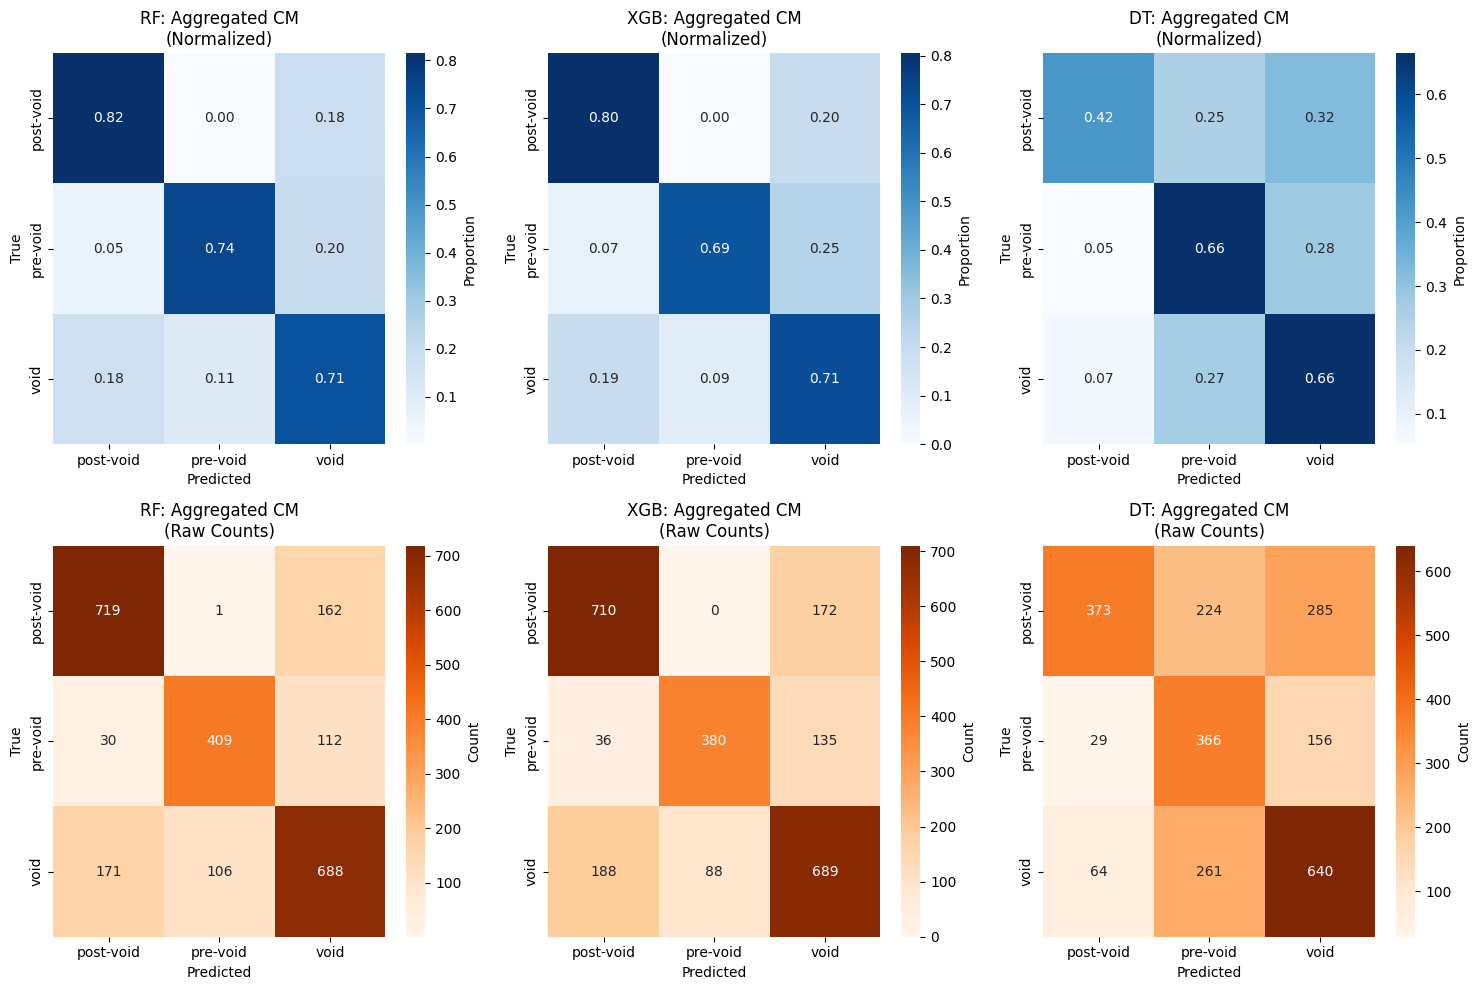

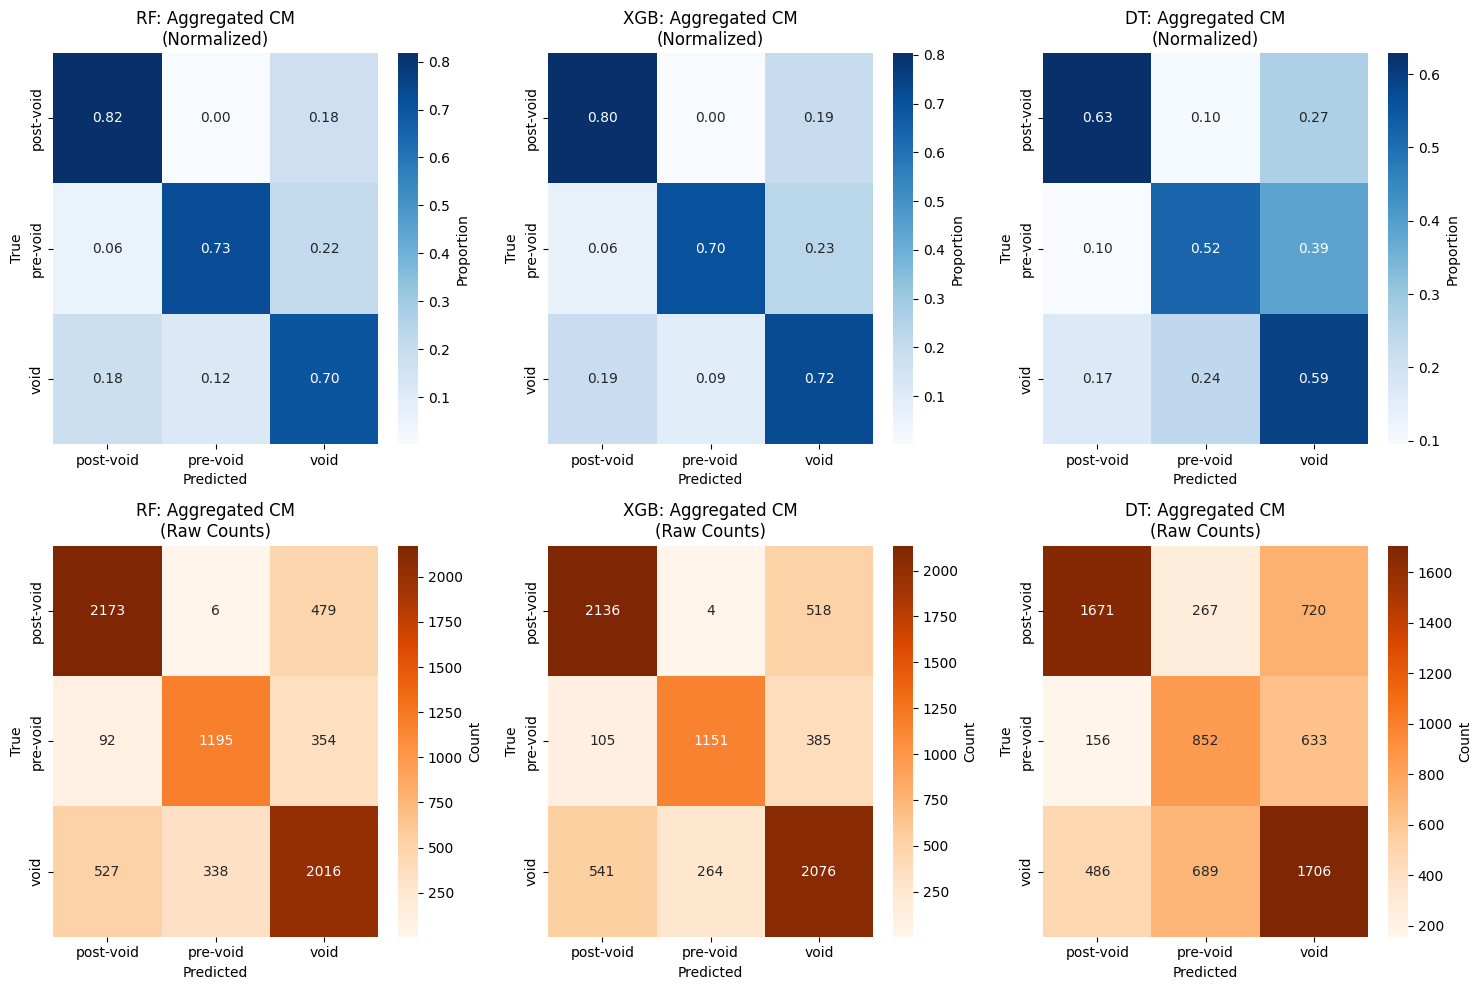

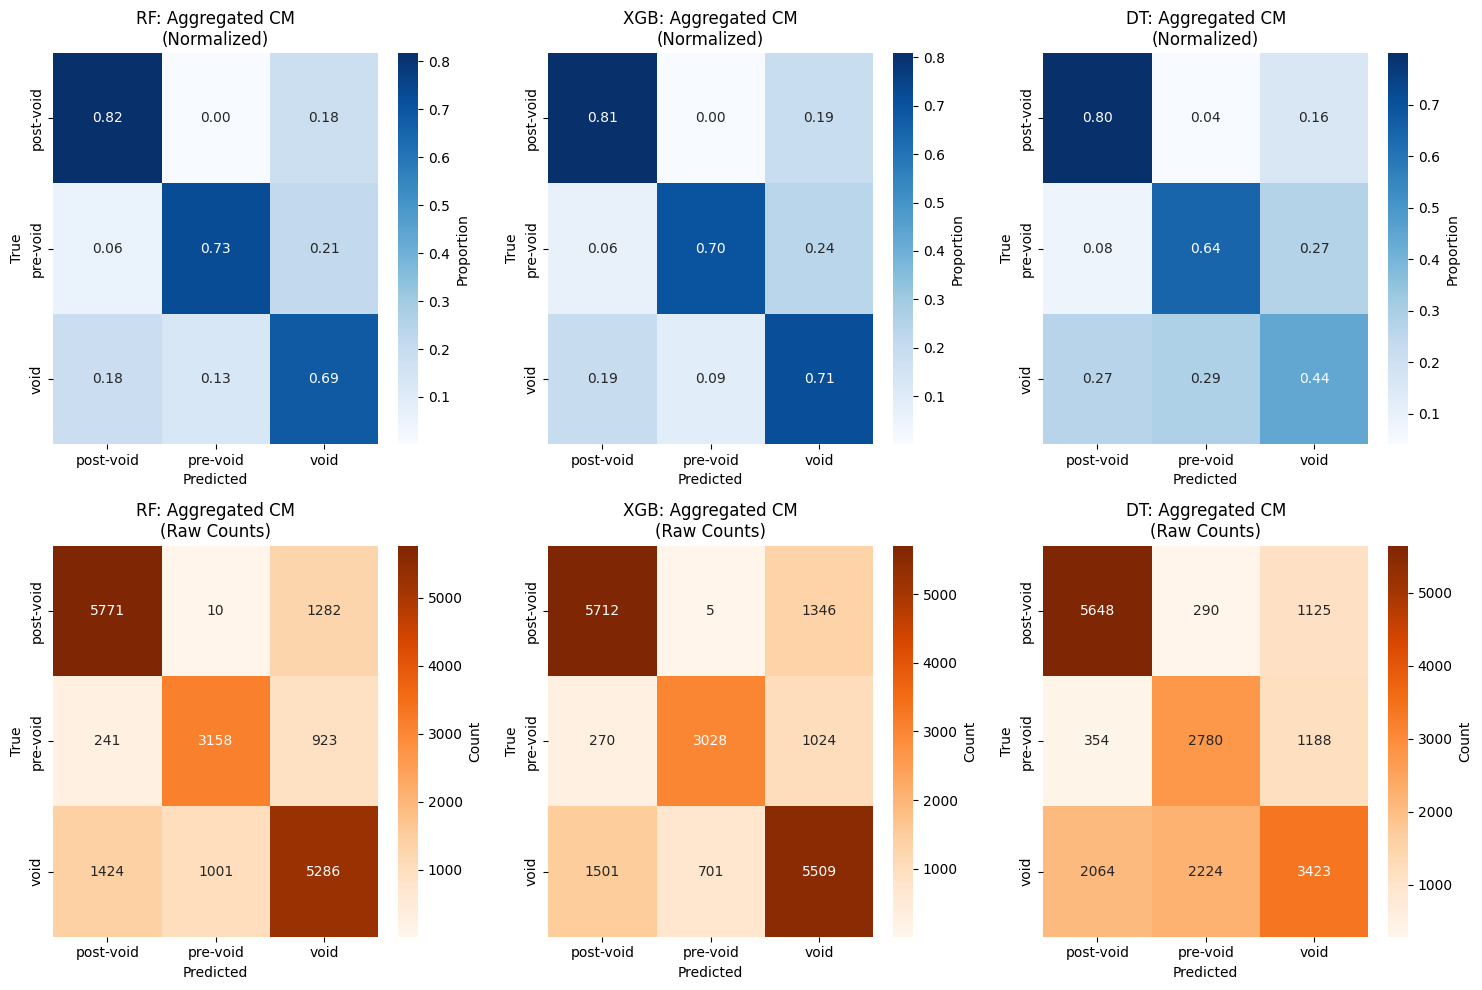

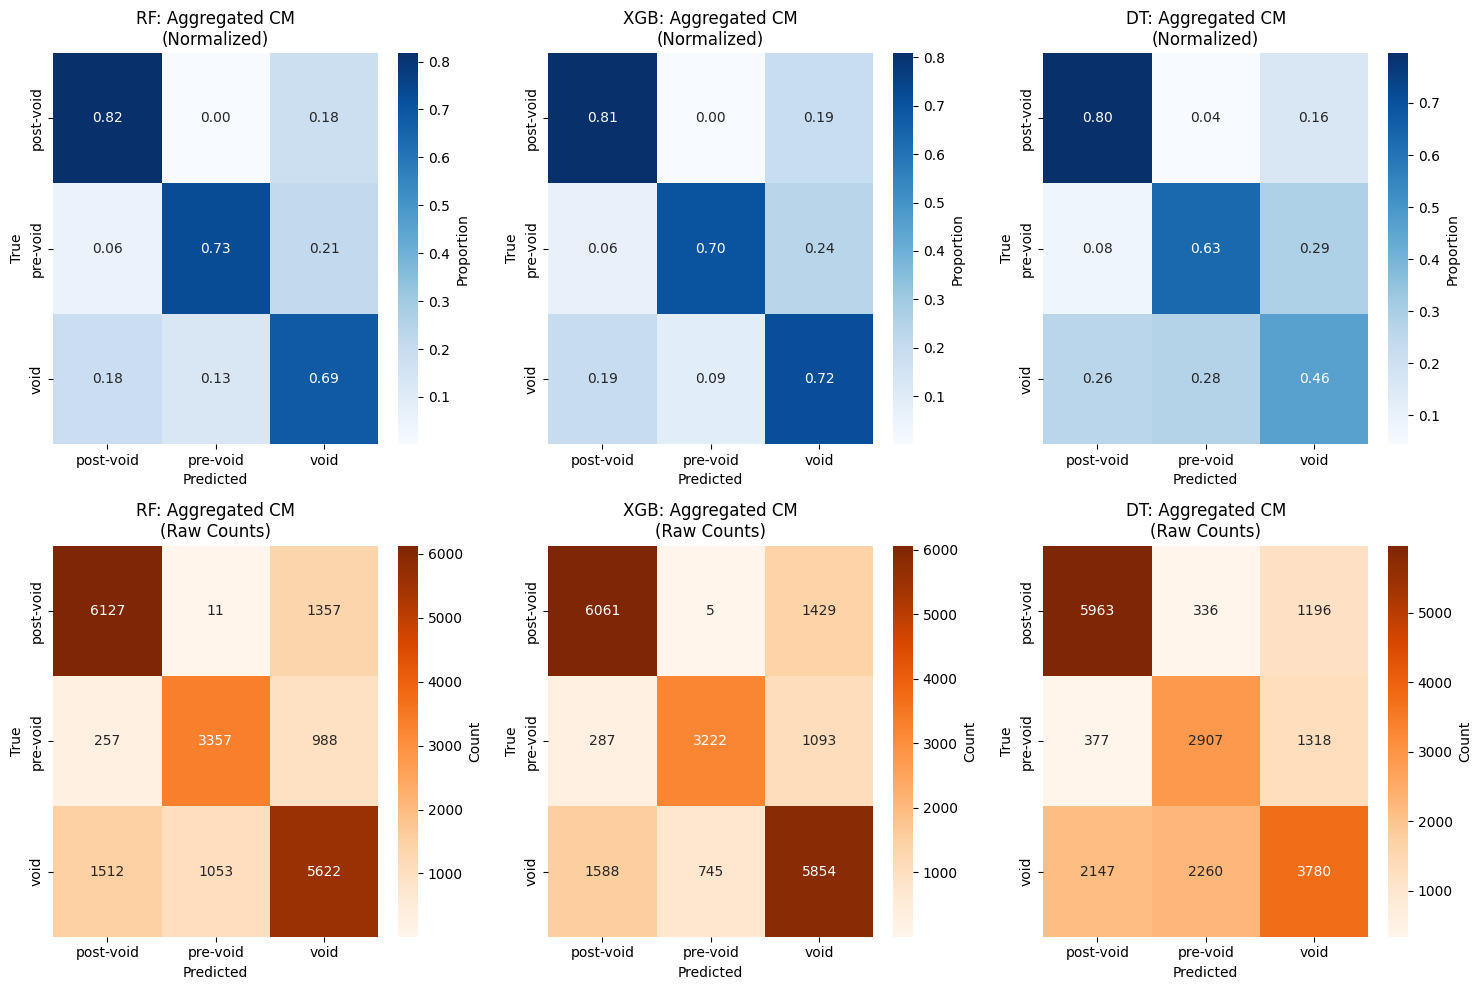

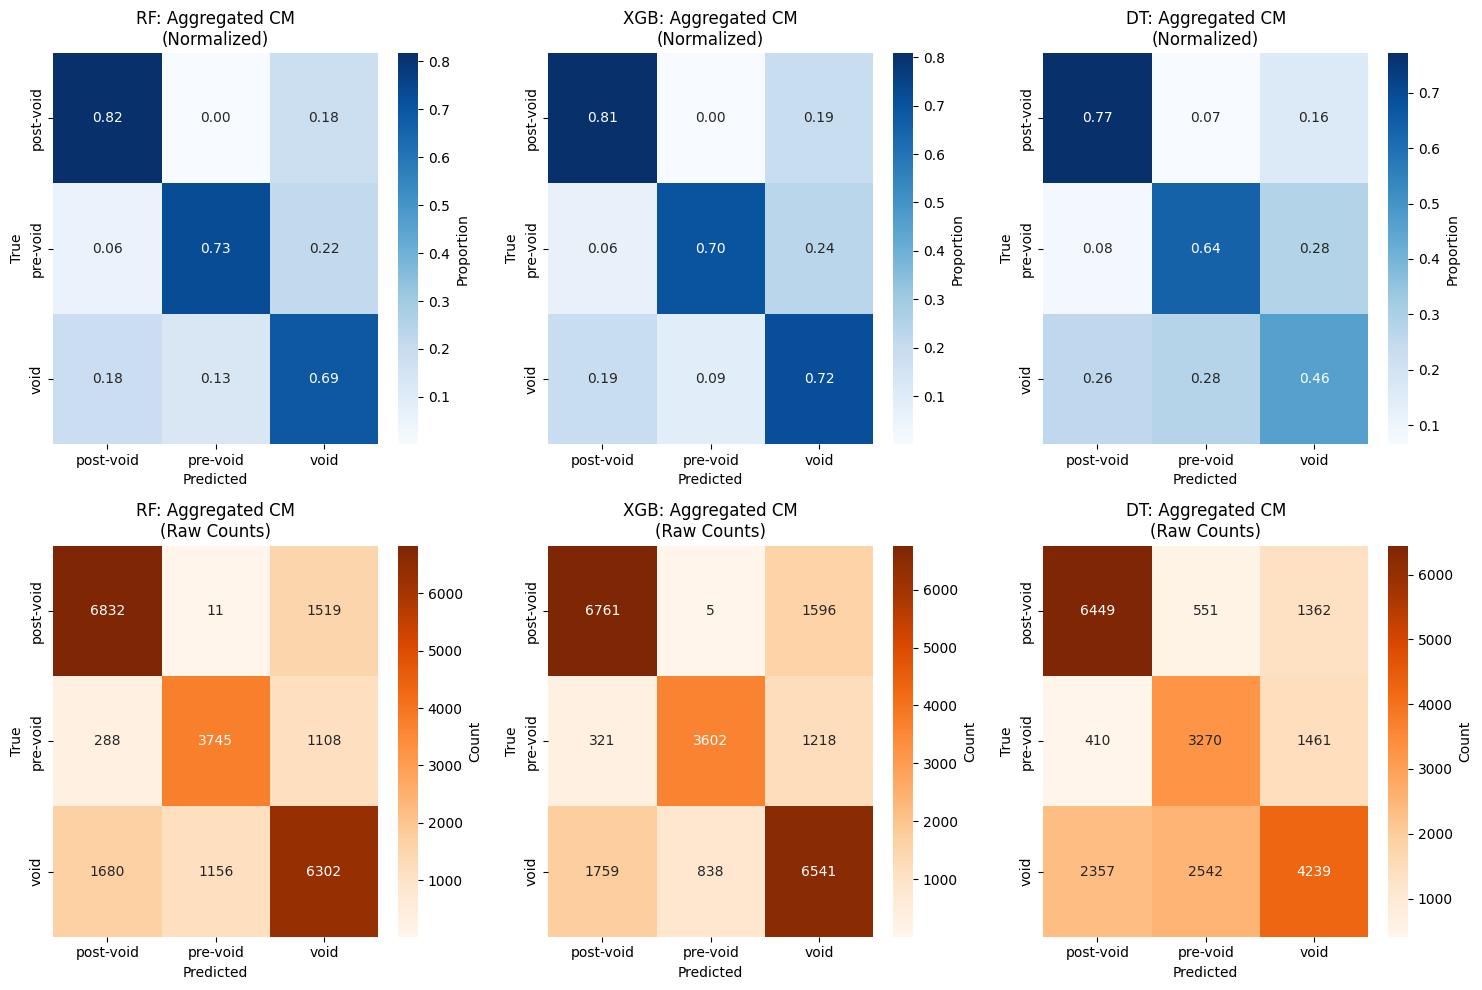

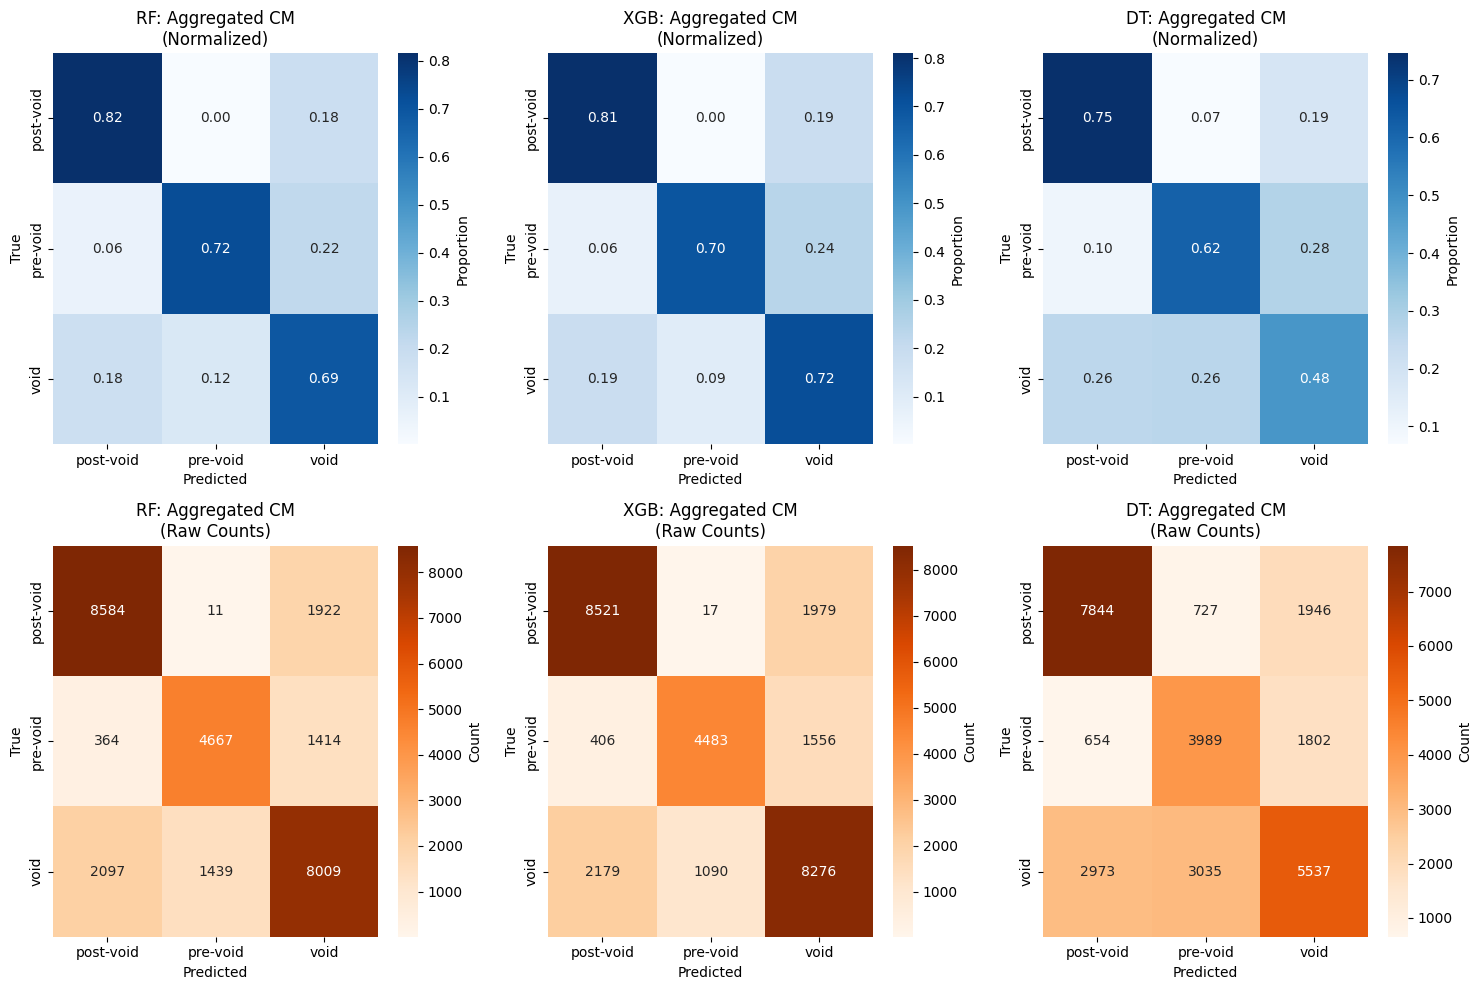

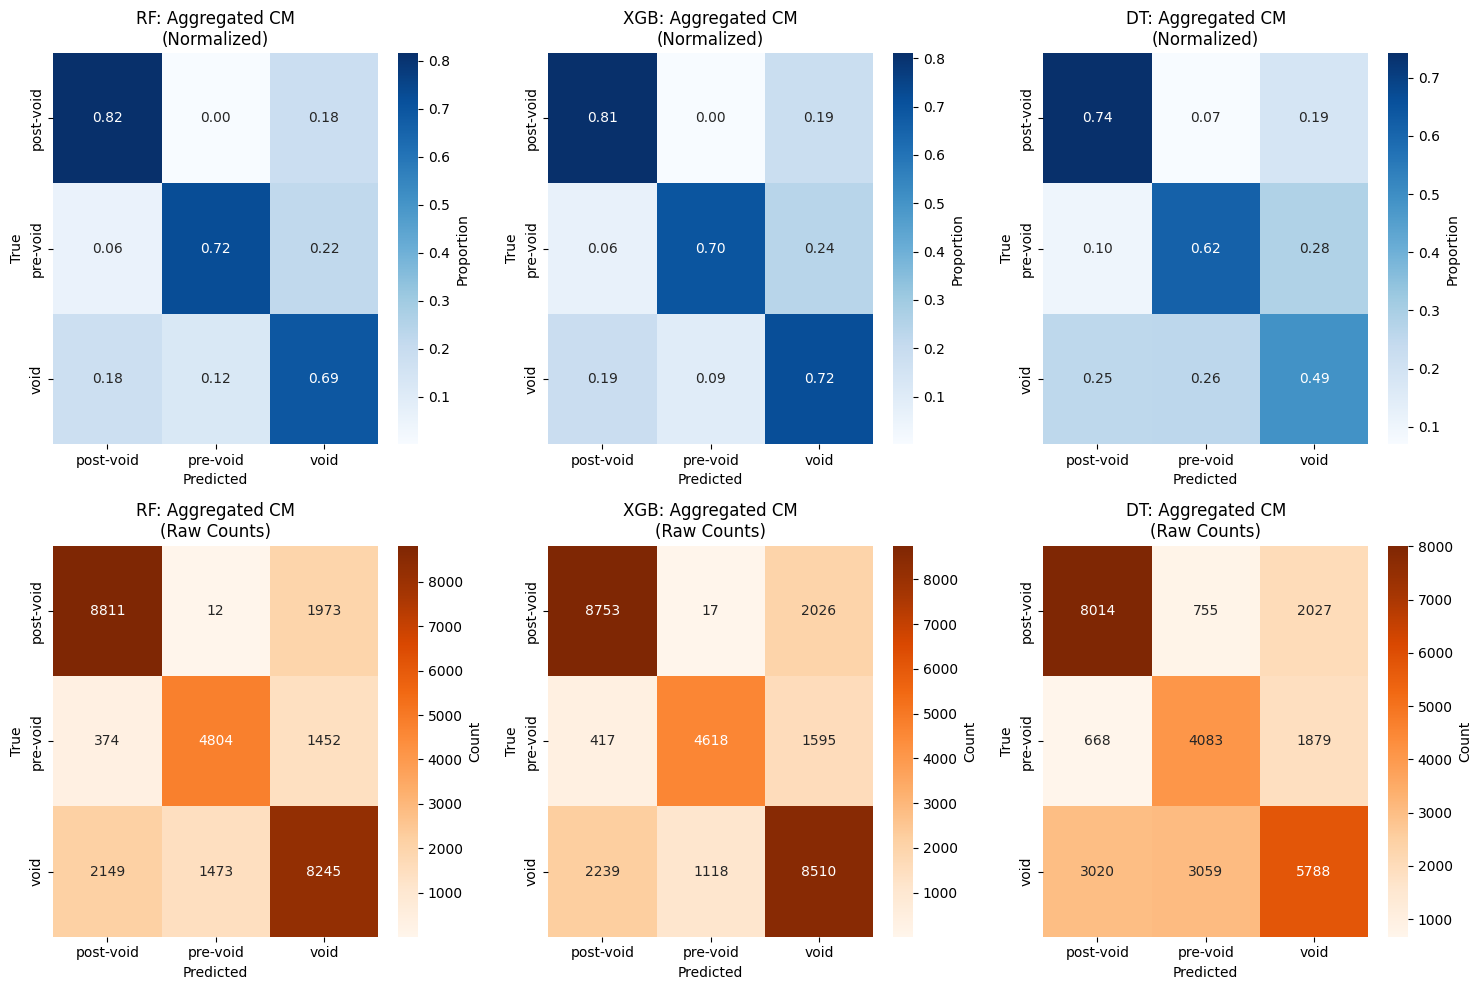

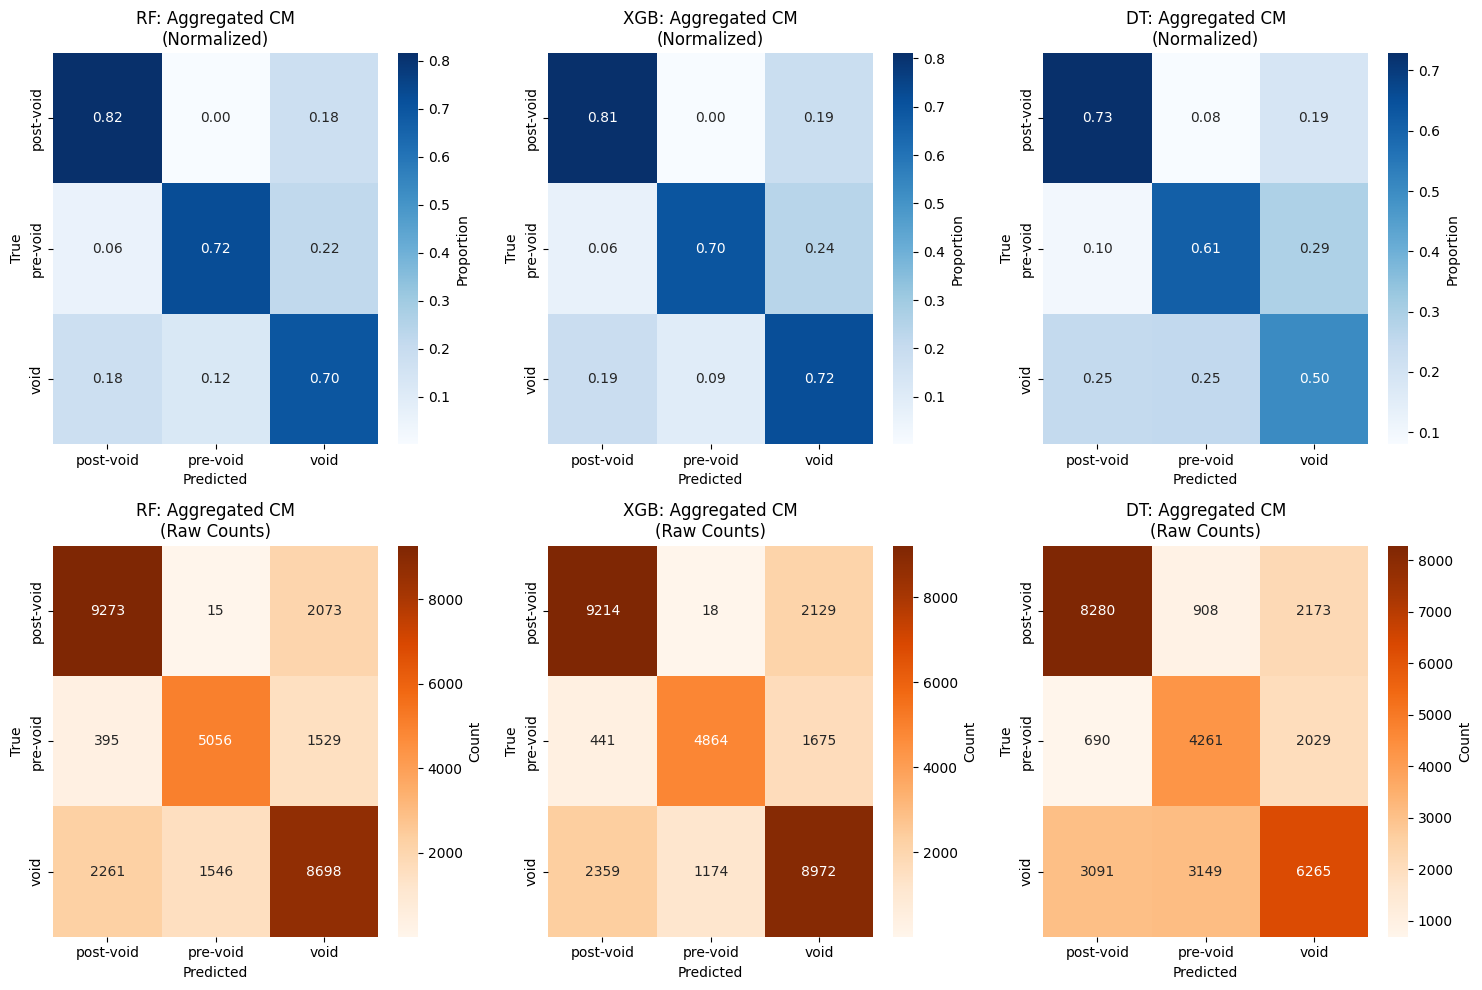

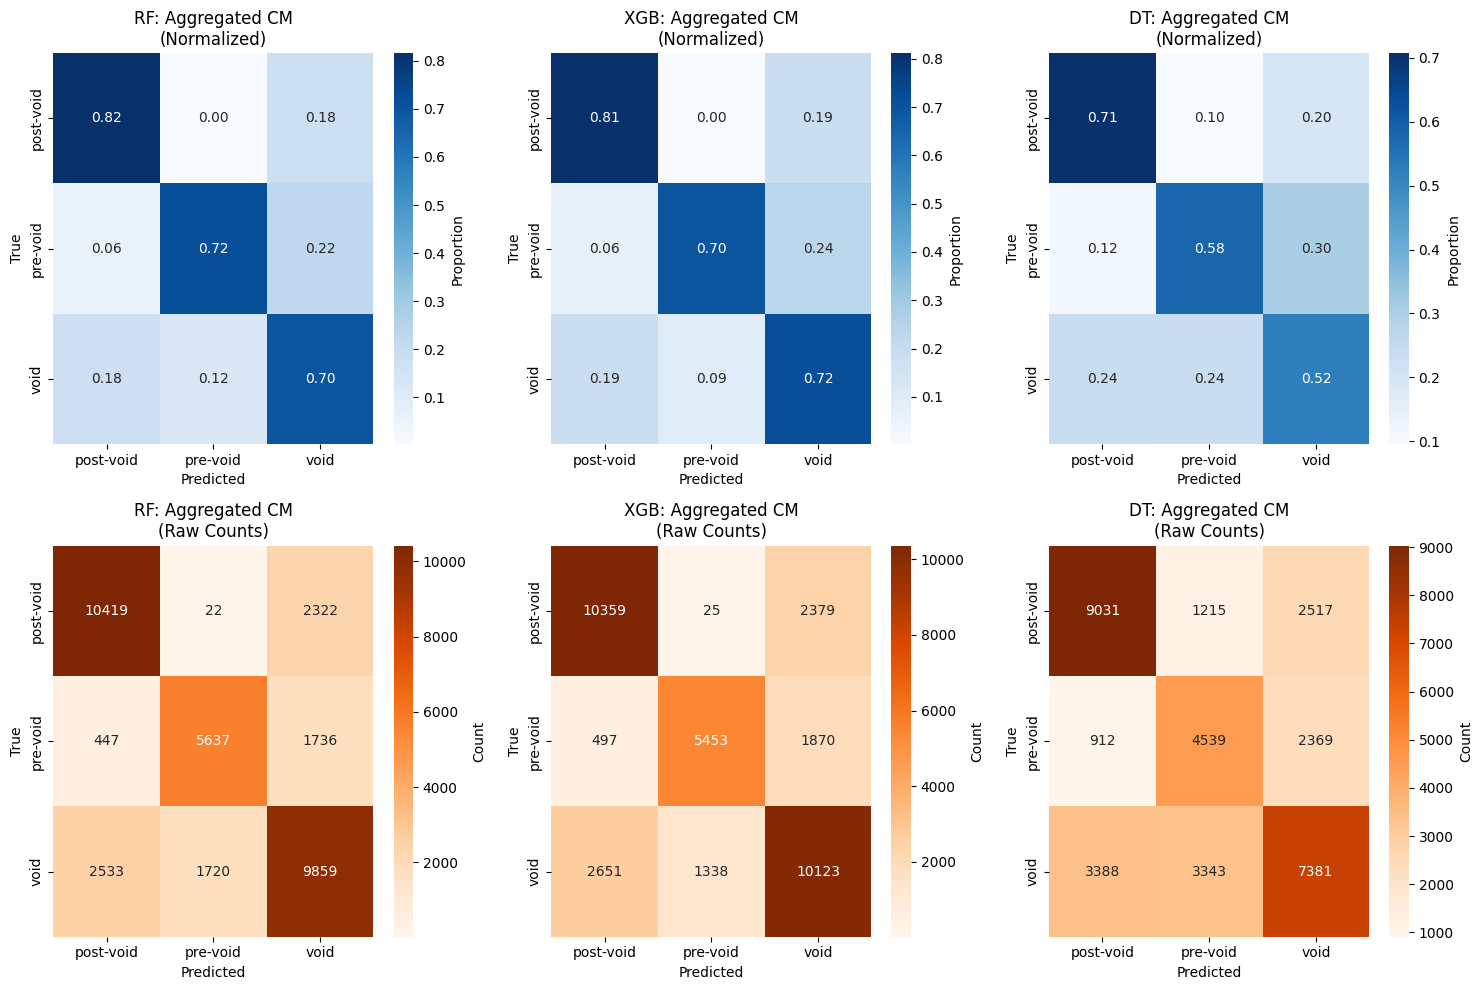

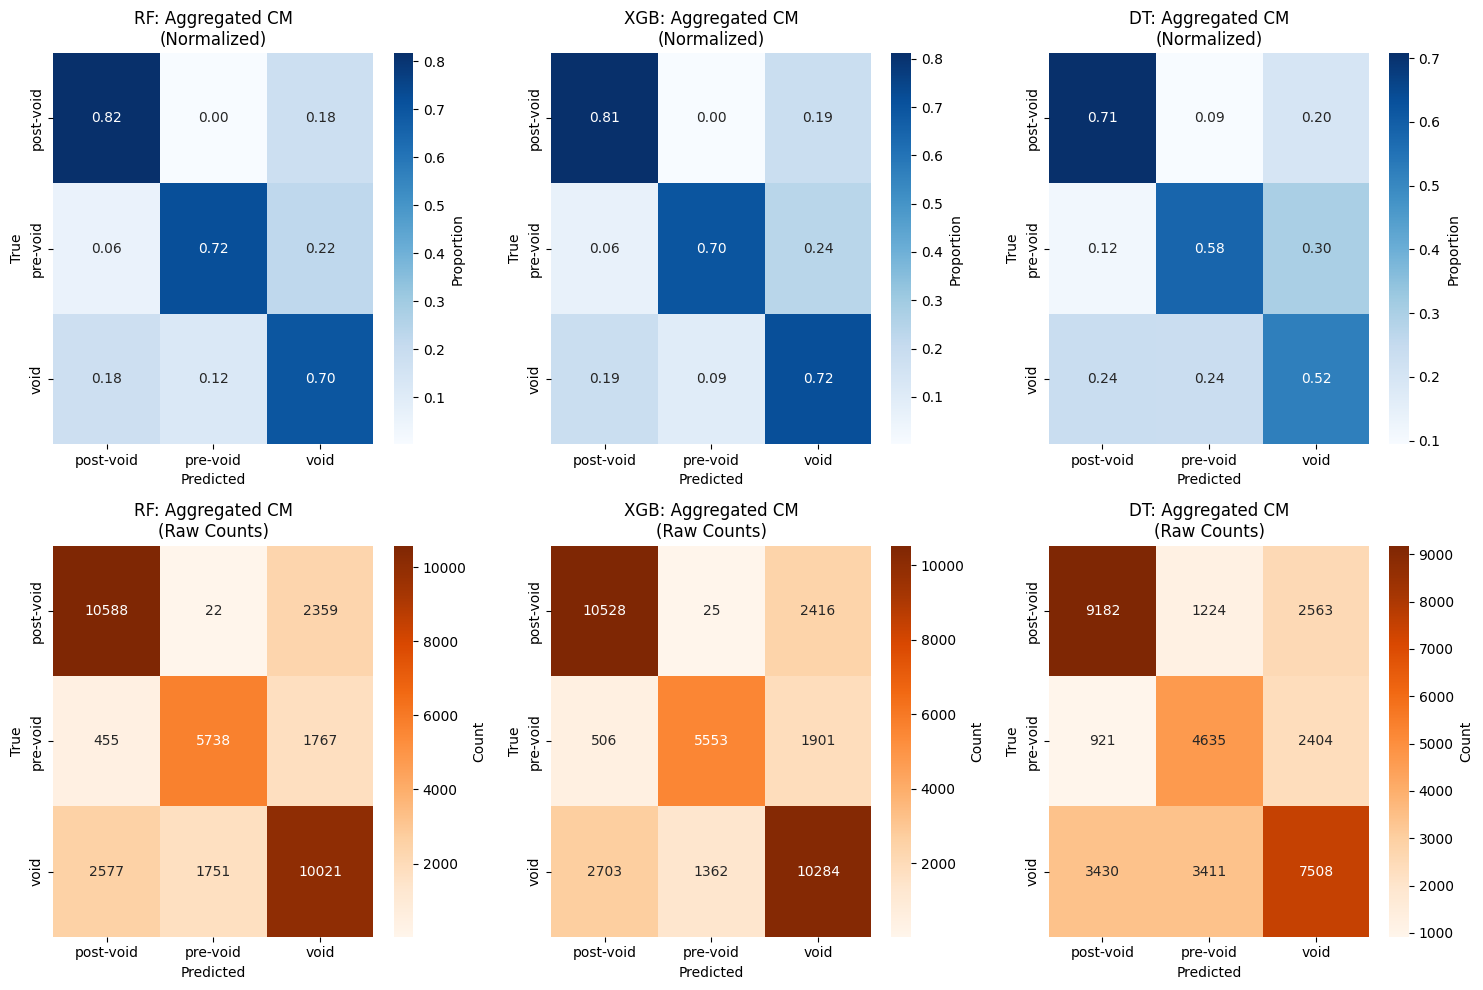

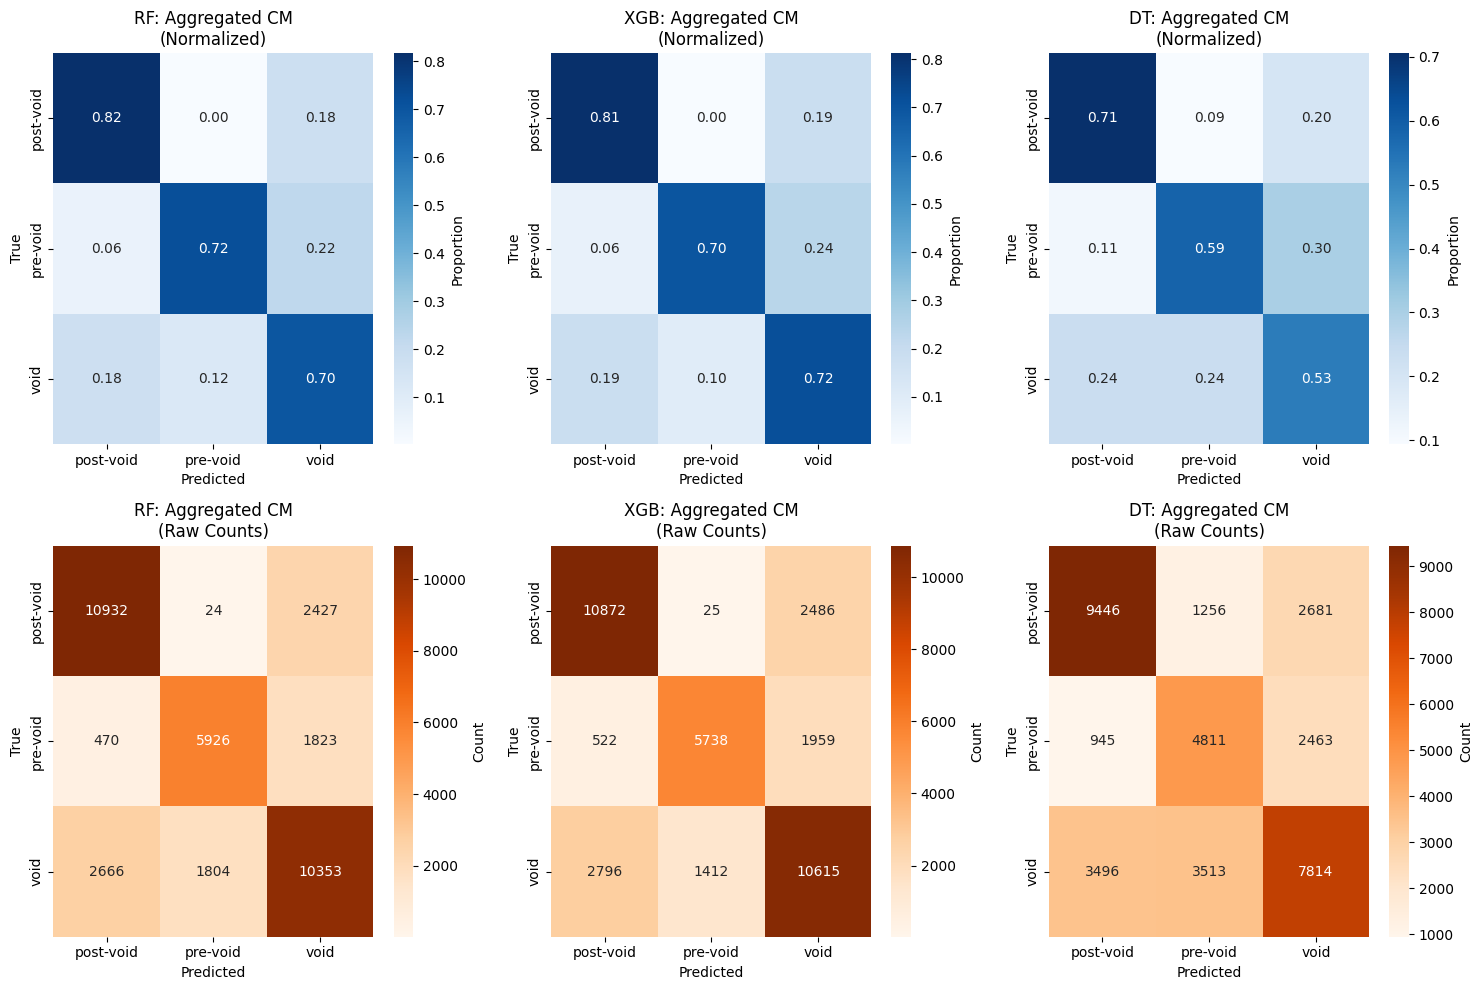

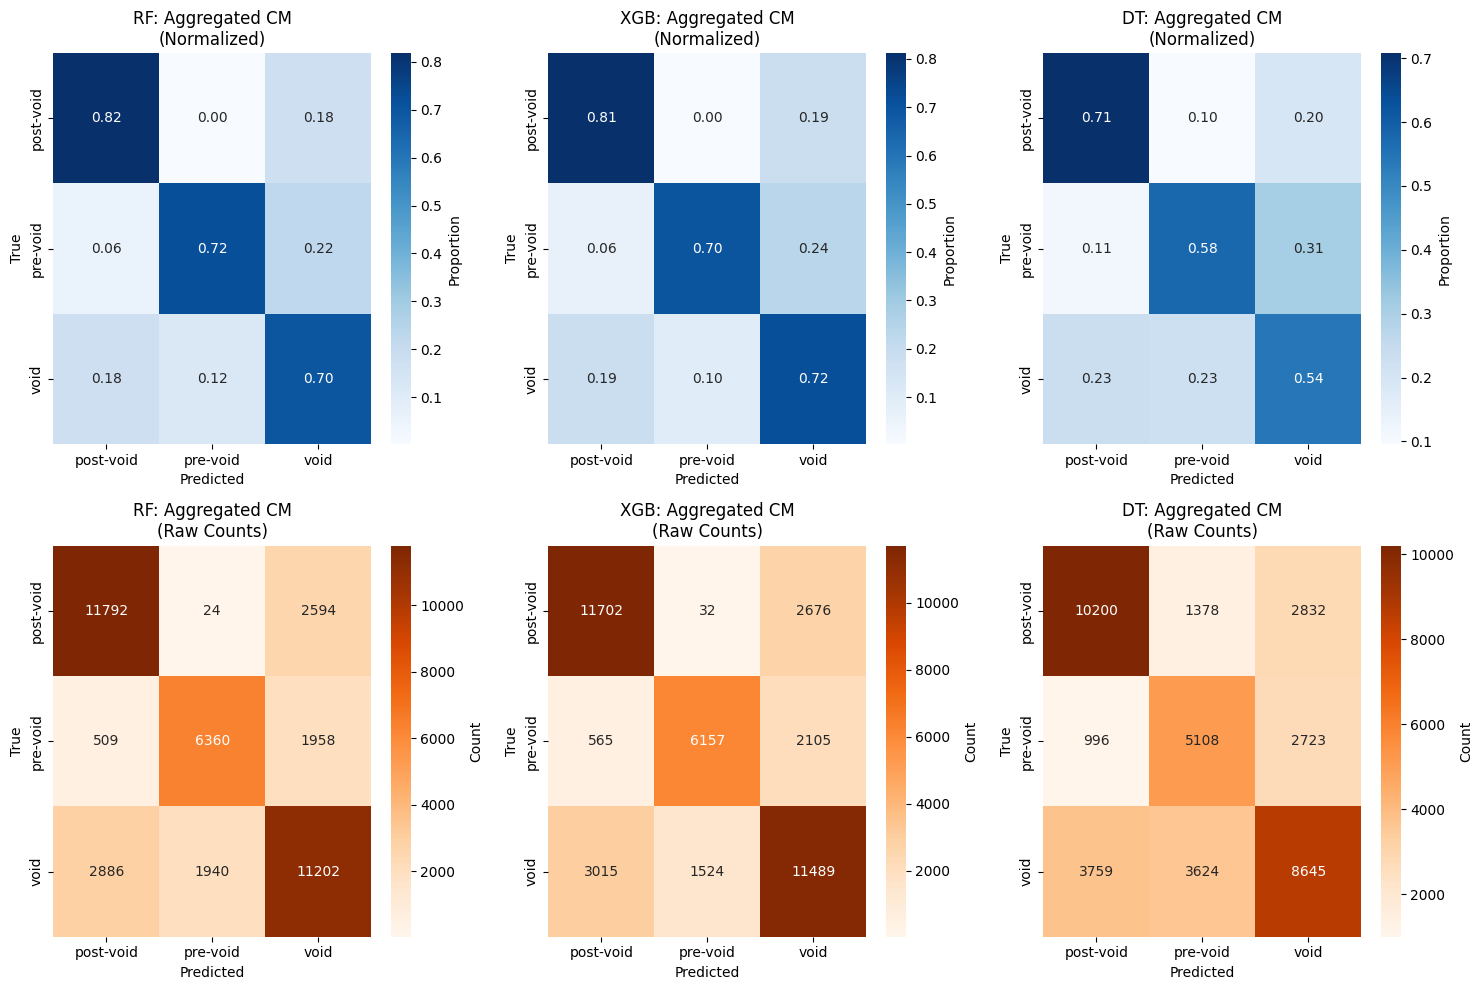

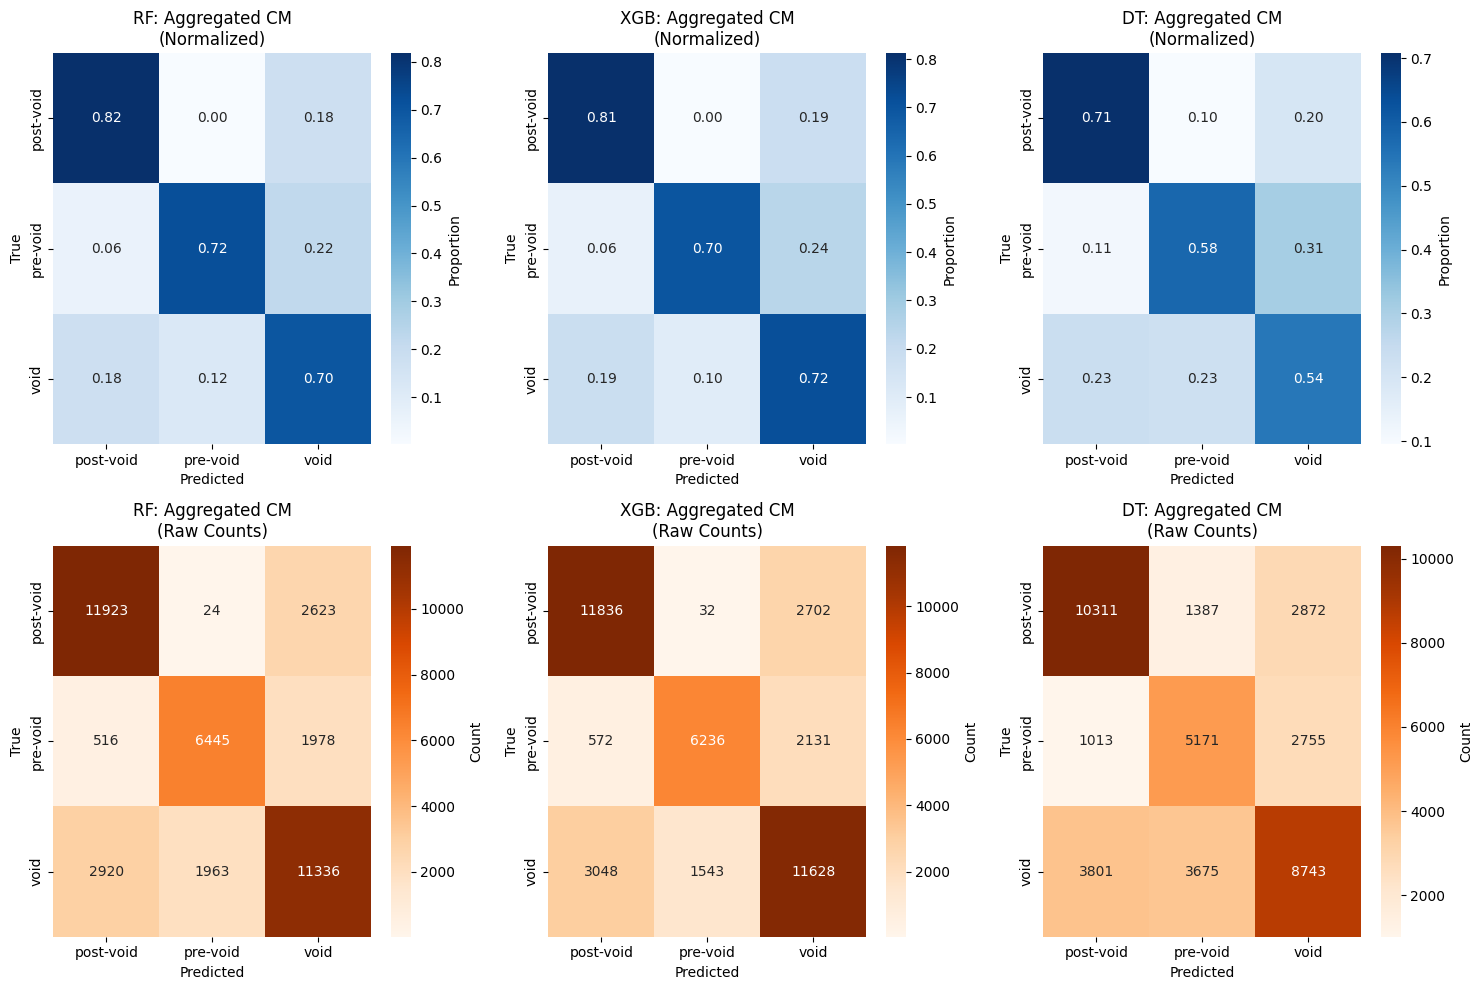

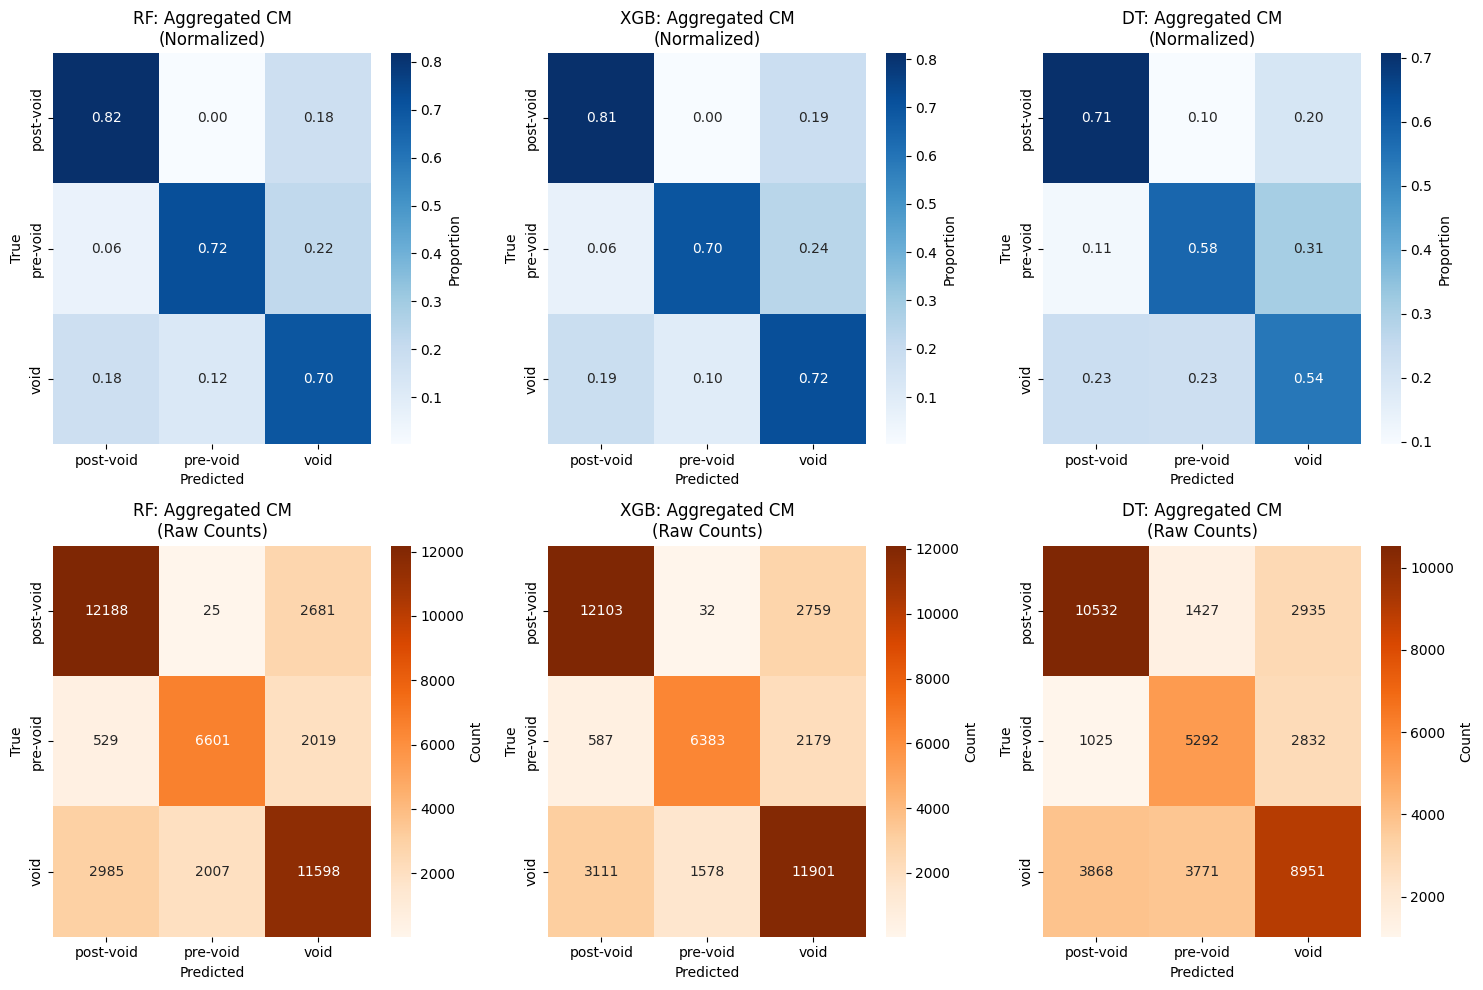

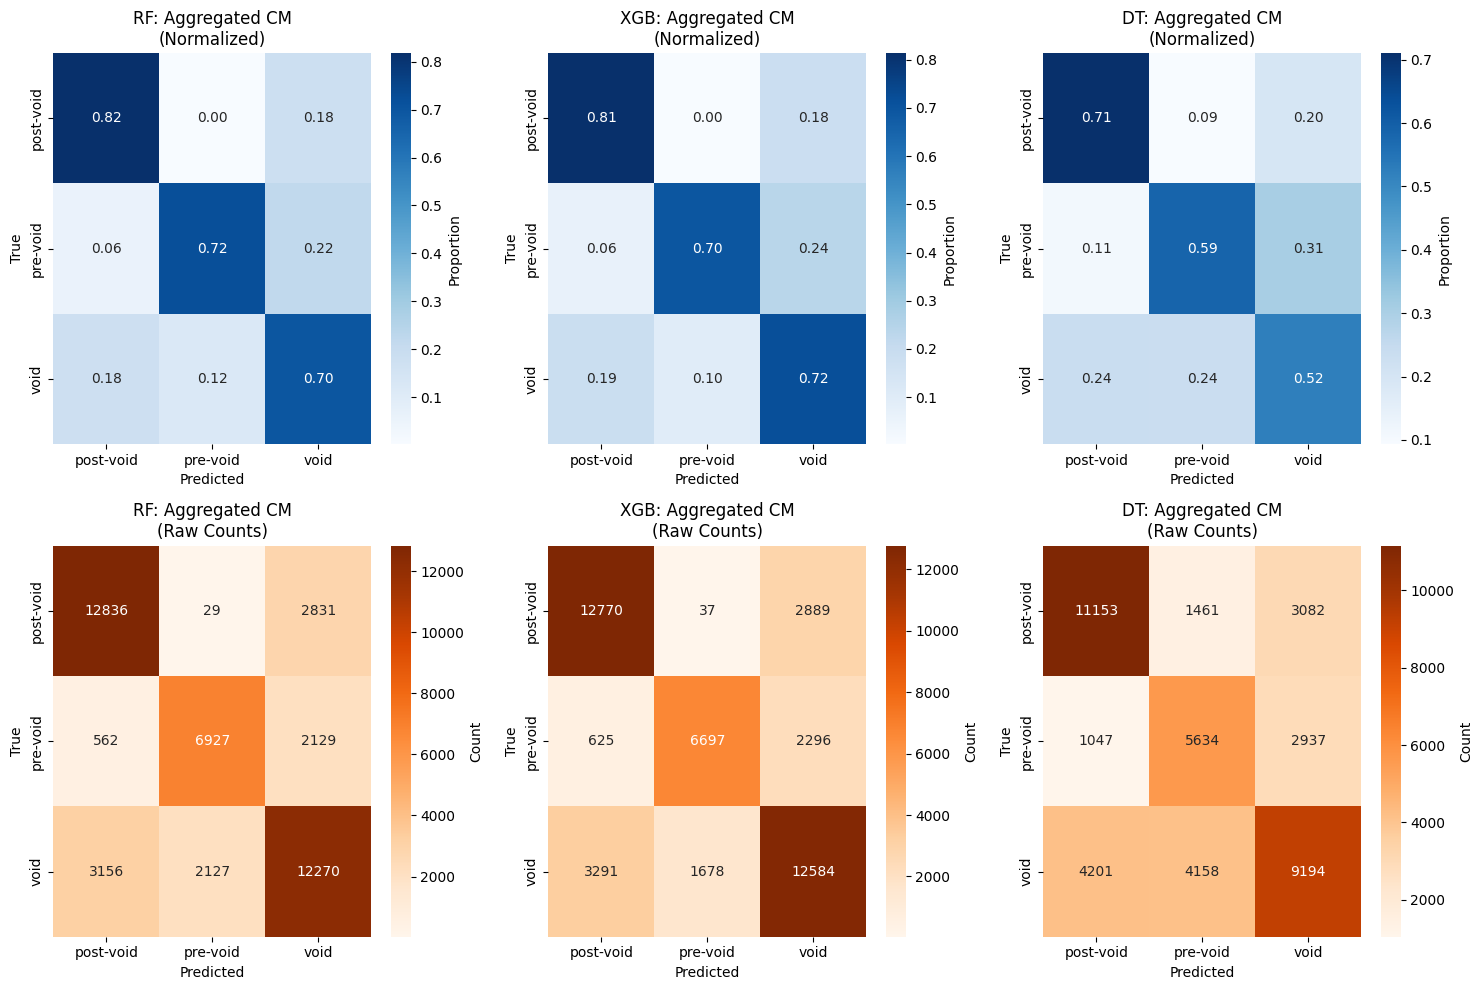

In [13]:
# Simple usage in your notebook:
base_save_path = '/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/global_normalization/nested_cv_results/three_class'

# Run everything with one function call
optimizer = run_global_norm_nested_cv_with_class(
    all_global_norm_results,
    base_save_path,
    n_inner_folds=3,
    n_trials=50
)

# Then analyze results easily:
best_config, best_model, best_f1 = optimizer.get_best_configuration()
print(f"Best: {best_config} with {best_model} - F1: {best_f1:.4f}")

# Compare specific configurations
comparison = optimizer.compare_configurations(['1s_0.5', '2s_0.5', '3s_0.5','3s', '5s_0.5','4s_0.5', '1s', '2s','4s','5s', '1s_0.8', '2s_0.8', '3s_0.8', '4s_0.8', '5s_0.8'])
print(comparison)

# Get detailed summary for best configuration
summary = optimizer.get_configuration_summary(best_config)
print(summary)




